# **Data-Science Fundamentals Final Project: predicting flights using ML algorithms**

## Stage No. 1: collecting the data:
- for this stage we will use a web scraper-collector that will collect flights data from two websites: Kiwi and Kayak.
- this collector is built with async-runtime functions, random user-actions generator, session saver, cookies saver, dynamic viewport and even DHCP-ip-refresher function (since were not using proxy), all of these methods are used for collecting without getting cought by these websities bot-identifier machenisms...
- this collector will run every combination of ttt (time to travel) from 1-30, los (lenght of stay) from 1-5 within a 3 different snapshot days for every combination of rome,london and paris routes

In [105]:
%pip install -e scraping
# %playwright install

Obtaining file:///C:/Users/Nadav/DS-Scarping/scraping
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py develop for scraping
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [106]:
# from scraping.flights_scraping import get_data

# get_data()

After we have collected the data: were doing the usual imports:

In [ ]:
# Basic imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import re, time, random, datetime, math
from datetime import datetime
from tqdm import tqdm

##################### Preprocessing imports 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from category_encoders import TargetEncoder, HashingEncoder, CountEncoder
from sklearn.impute import KNNImputer

##################### Metrics
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

##################### Models
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline

##################### Model selection 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingRegressor
from sklearn.inspection import permutation_importance
from sklearn.base import clone
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import minimize
from IPython.display import clear_output
from concurrent.futures import ThreadPoolExecutor
from scipy.stats import skew, kurtosis

##################### optuna library import
# !pip install shap
import optuna
# import shap
import matplotlib.cm as cm
from collections import defaultdict
from currency_converter import CurrencyConverter

##################### Basic settings
random_state = 42
n_splits = 5

## Stage 2: Exploring the data

In [108]:
data = pd.read_csv('Flights.csv')

In [109]:
# Table for first look
def summary(train):
    sum = pd.DataFrame(train.dtypes, columns=['dtypes'])
    sum['missing#'] = train.isna().sum()
    sum['missing%'] = (train.isna().sum())/len(train)
    sum['uniques'] = train.nunique().values
    sum['count'] = train.count().values
    return sum

display(summary(data).style.background_gradient(cmap='Blues'))
data.head()

,dtypes,missing#,missing%,uniques,count
departure_hour,object,33498,0.067904,415,459813
departure_airport,object,38721,0.078492,13,454590
flight_length,object,33498,0.067904,170,459813
landing_hour,object,37733,0.076489,431,455578
landing_airport,object,38000,0.077031,13,455311
to_dest_company,object,42175,0.085494,35,451136
return_departure_hour,object,33498,0.067904,413,459813
return_departure_airport,object,38693,0.078435,211,454618
return_flight_length,object,33498,0.067904,167,459813
return_landing_hour,object,38693,0.078435,442,454618


,departure_hour,departure_airport,flight_length,landing_hour,landing_airport,to_dest_company,return_departure_hour,return_departure_airport,return_flight_length,return_landing_hour,...,ttt,los,snapshot_date,origin_city,destination_city,departure_date,return_date,website,layover_time,return_layover_time
0,6:00a,CIA,2h 45m,7:45a,STN,Ryanair,6:10p,STN,2h 25m,9:35p,...,2,1,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kayak,0m,0m
1,6:35a,FCO,2h 45m,8:20a,LGW,Wizz Air,9:10a,STN,2h 30m,12:40p,...,2,1,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kayak,0m,0m
2,6:35a,FCO,2h 45m,8:20a,LGW,Wizz Air,6:10p,STN,2h 25m,9:35p,...,2,1,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kayak,0m,0m
3,6:00a,CIA,2h 45m,7:45a,STN,Ryanair,6:10p,STN,2h 25m,9:35p,...,2,1,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kayak,0m,0m
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,1,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kayak,0m,0m


## Stage 3: Preprocessing
<!-- <ul>
    <li>basic_cleanups</li>
    <li></li>
    <li></li>
</ul> -->

the price is still an object! we need to convert it to numerical... (with scraping knowlage we know that kiwi gives the price in nis and kayak in $)

In [110]:
%pip install currencyconverter

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [111]:
def basic_cleanups(data):
    data = data.drop_duplicates()
    data = data.dropna()

    c = CurrencyConverter()

    data['price'] = data['price'].apply(
        lambda x: (
            c.convert(float(x.replace('₪ ', '').replace(',', '')), 'ILS', 'USD') if '₪ ' in x
            else float(x.replace('$', '').replace(',', '')) if '$' in x 
            else None 
        )
    )
    return data

we will add a function that will convert the time strings to int (in minutes)

In [112]:
def time_to_minutes(time_str: str)-> int:
    if pd.isna(time_str):
        return 0

    # Extract hours and minutes using regex
    hours = 0
    minutes = 0
    
    h_match = re.search(r'(\d+)h', time_str)
    m_match = re.search(r'(\d+)m', time_str)

    if h_match:
        hours = int(h_match.group(1))
    if m_match:
        minutes = int(m_match.group(1))

    return hours * 60 + minutes

In [113]:
def hour_to_numeric(hour_str):
    '''
    convert the hours to int format
    '''
    hour_str = hour_str.strip()  

    match = re.search(r"\+(\d+)", hour_str)
    extra_days = int(match.group(1)) if match else 0
    hour_str = re.sub(r"\+\d+", "", hour_str)
    
    if 'a' in hour_str or 'p' in hour_str:
        hour_str = hour_str.replace('a', 'AM').replace('p', 'PM')

        time_obj = datetime.strptime(hour_str, "%I:%M%p")
    else:
        time_obj = datetime.strptime(hour_str, "%H:%M")

    hour_float = time_obj.hour + time_obj.minute / 60

    hour_float += extra_days * 24

    return hour_float


In [114]:
def preprocessing(data):
    # perform basic cleanups
    data = basic_cleanups(data)

    # convert time to minutes
    data['flight_length'] = data['flight_length'].apply(time_to_minutes)
    data['return_flight_length'] = data['return_flight_length'].apply(time_to_minutes)
    data['layover_time'] = data['layover_time'].apply(time_to_minutes)
    data['return_layover_time'] = data['return_layover_time'].apply(time_to_minutes)

    # convert hours to numeric
    data['departure_hour'] = data['departure_hour'].apply(hour_to_numeric)
    data['landing_hour'] = data['landing_hour'].apply(hour_to_numeric)
    data['return_departure_hour'] = data['return_departure_hour'].apply(hour_to_numeric)
    data['return_landing_hour'] = data['return_landing_hour'].apply(hour_to_numeric)

    # convert date to datetime
    ## we know that dates are tied to day of week, lets create new feature based on the departure date!
    data['departure_date'] = pd.to_datetime(data['departure_date'])
    data['day_of_week'] = data['departure_date'].dt.day_name()

    # create new feature based on the origin_city and destination_city
    data['route'] = data['origin_city'] + '_' + data['destination_city']

    return data

data = preprocessing(data)
data.head()

,departure_hour,departure_airport,flight_length,landing_hour,landing_airport,to_dest_company,return_departure_hour,return_departure_airport,return_flight_length,return_landing_hour,...,snapshot_date,origin_city,destination_city,departure_date,return_date,website,layover_time,return_layover_time,day_of_week,route
0,6.0000,CIA,165,7.7500,STN,Ryanair,18.1667,STN,145,21.5833,...,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kayak,0,0,Sunday,ROME_LONDON
1,6.5833,FCO,165,8.3333,LGW,Wizz Air,9.1667,STN,150,12.6667,...,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kayak,0,0,Sunday,ROME_LONDON
2,6.5833,FCO,165,8.3333,LGW,Wizz Air,18.1667,STN,145,21.5833,...,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kayak,0,0,Sunday,ROME_LONDON
5,6.5833,FCO,165,8.3333,LGW,Wizz Air,21.0000,LGW,150,24.5000,...,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kayak,0,0,Sunday,ROME_LONDON
6,6.5833,FCO,165,8.3333,LGW,Wizz Air,6.2500,STN,145,9.6667,...,2025-02-28,ROME,LONDON,2025-03-02,2025-03-03,Kayak,0,0,Sunday,ROME_LONDON


We have find a mistake in the dataset where there are a lot of invalid values inside of the feature return_departure_airport - Some of the values (around 80-90K values) only contain an hour. Therefore the best direction at the moment is to turn all the invalid values to Nans 

In [115]:
value_counts = data['return_departure_airport'].value_counts()

# Temporarily increase the maximum rows to display
with pd.option_context('display.max_rows', None):
    print(value_counts)

return_departure_airport
FCO      82301
ORY      72126
LGW      71877
CDG      49974
STN      28977
LHR      14249
LTN      14221
CIA      12458
BVA       9537
11:35     1928
11:50     1917
08:20     1874
17:45     1791
09:20     1700
08:35     1359
12:50     1359
10:15     1346
07:45     1312
14:25     1251
18:25     1232
09:10     1219
12:35     1207
09:25     1195
SEN       1139
10:35     1125
08:40     1095
20:20     1024
23:15      993
08:25      953
LCY        953
16:55      933
22:30      928
12:40      910
21:45      887
08:55      868
19:50      855
08:05      797
15:20      754
20:05      750
15:25      745
09:40      741
21:40      738
08:10      719
07:30      713
12:05      703
19:40      697
19:35      694
19:05      665
17:20      661
16:20      636
11:00      629
20:30      624
18:50      612
18:55      600
19:25      598
12:25      588
10:20      585
13:20      584
09:30      573
10:40      563
21:35      559
21:50      552
16:05      551
19:30      549
11:10      543


In [185]:
def replace_time_with_nan(df, column_name):
    """Replaces time patterns (HH:MM) in a specified DataFrame column with NaN."""

    time_pattern = r'^\d{2}:\d{2}$'  # Matches HH:MM format (e.g., 11:35)

    df[column_name] = df[column_name].replace(to_replace=time_pattern, value=np.nan, regex=True)

    return df

replace_time_with_nan(data,'return_departure_airport')

,departure_hour,departure_airport,flight_length,landing_hour,landing_airport,to_dest_company,return_departure_hour,return_departure_airport,return_flight_length,return_landing_hour,...,origin_city,destination_city,departure_date,return_date,website,layover_time,return_layover_time,day_of_week,route,time_category
0,17.5833,LHR,80,19.9167,CDG,Air France,18.0000,CDG,80,18.3333,...,LONDON,PARIS,2025-03-01,2025-03-02,Kayak,0,0,Saturday,LONDON_PARIS,Afternoon_12_18
1,12.0000,LGW,75,14.2500,CDG,easyJet,7.0000,CDG,80,7.3333,...,LONDON,PARIS,2025-03-01,2025-03-02,Kayak,0,0,Saturday,LONDON_PARIS,Morning_6_12
2,12.7500,LGW,80,15.0833,ORY,Vueling,7.0000,CDG,80,7.3333,...,LONDON,PARIS,2025-03-01,2025-03-02,Kayak,0,0,Saturday,LONDON_PARIS,Afternoon_12_18
3,12.7500,LGW,80,15.0833,ORY,Vueling,7.0000,ORY,70,7.1667,...,LONDON,PARIS,2025-03-01,2025-03-02,Kayak,0,0,Saturday,LONDON_PARIS,Afternoon_12_18
4,12.7500,LGW,80,15.0833,ORY,Vueling,7.0000,CDG,80,7.3333,...,LONDON,PARIS,2025-03-01,2025-03-02,Kayak,0,0,Saturday,LONDON_PARIS,Afternoon_12_18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422044,18.0833,FCO,135,20.3333,BVA,Ryanair,21.6667,NaN,120,23.6667,...,ROME,PARIS,2025-04-01,2025-04-02,Kiwi,0,0,Tuesday,ROME_PARIS,Evening_18_24
422045,20.3333,FCO,125,22.4167,ORY,easyJet,17.2500,NaN,125,19.3333,...,ROME,PARIS,2025-04-01,2025-04-02,Kiwi,0,0,Tuesday,ROME_PARIS,Evening_18_24
422046,13.5833,FCO,130,15.7500,ORY,Vueling,16.8333,NaN,125,18.9167,...,ROME,PARIS,2025-04-01,2025-04-02,Kiwi,0,0,Tuesday,ROME_PARIS,Afternoon_12_18
422047,9.8333,FCO,135,12.0833,ORY,Vueling,17.2500,NaN,125,19.3333,...,ROME,PARIS,2025-04-01,2025-04-02,Kiwi,0,0,Tuesday,ROME_PARIS,Morning_6_12


## Stage 4 - EDA
<ul>
    <li>Target Column</li>
    <li></li>
</ul>

c:\Users\Nadav\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


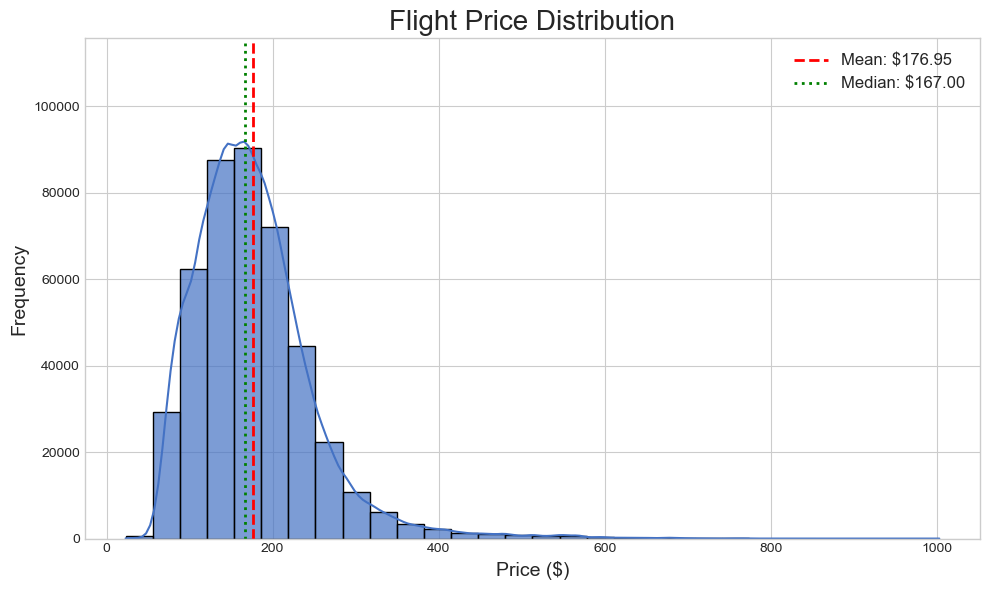

The target variable kurtosis is 6.22985229583405
The target variable skew is 1.7049776125112948


In [117]:
def TargetCol(data): 
    '''Target column analysis - which in this case is the price column distribution'''
    plt.style.use('seaborn-v0_8-whitegrid')

    plt.figure(figsize=(10, 6))
    plt.title('Flight Price Distribution', fontsize=20)

    sns.histplot(data['price'], bins=30, kde=True, color='#4472C4', 
                edgecolor='black', alpha=0.7)

    mean_price = data['price'].mean()
    median_price = data['price'].median()
    plt.axvline(mean_price, color='red', linestyle='--', linewidth=2, 
                label=f'Mean: ${mean_price:.2f}')
    plt.axvline(median_price, color='green', linestyle=':', linewidth=2, 
                label=f'Median: ${median_price:.2f}')

    plt.ylim(0, plt.ylim()[1] * 1.2)

    plt.xlabel('Price ($)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.legend(fontsize=12)

    plt.tight_layout()
    plt.show()

    print(f"The target variable kurtosis is {kurtosis(data['price'])}")
    print(f"The target variable skew is {skew(data['price'])}")
    
TargetCol(data)

The results of the kurtosis and skew mean that the price target 

In [118]:
data_value_counts = data['to_dest_company'].value_counts()
data_value_counts = pd.DataFrame(data_value_counts).style.background_gradient("cool")
data_value_counts

,count
to_dest_company,
easyJet,121360
Vueling,97014
Ryanair,76422
Wizz Air,34636
ITA Airways,26677
British Airways,26492
Transavia France,18721
Air France,12428
Wizz Air Malta,10191


There is A lot of data 

In [119]:
company_mapping = {
    'Wizz Air Malta': 'Wizz Air',
    'Wizz Air UK': 'Wizz Air',
    'Ryanair UK': 'Ryanair',
    'Multiple airlines': 'Other',
    'Scandinavian Airlines': 'SAS',
    'KM Malta Airlines': 'Other',
    'Aeroitalia': 'Other',
    'FlixBus': 'Other',
    'BlaBlaBus': 'Other',
    'Union Ivkoni': 'Other',
    'Brussels Airlines': 'Other',
    'SWISS': 'Other',
    'Volotea': 'Other'
}

data['to_dest_company'] = data['to_dest_company'].replace(company_mapping)
data['return_company'] = data['return_company'].replace(company_mapping)

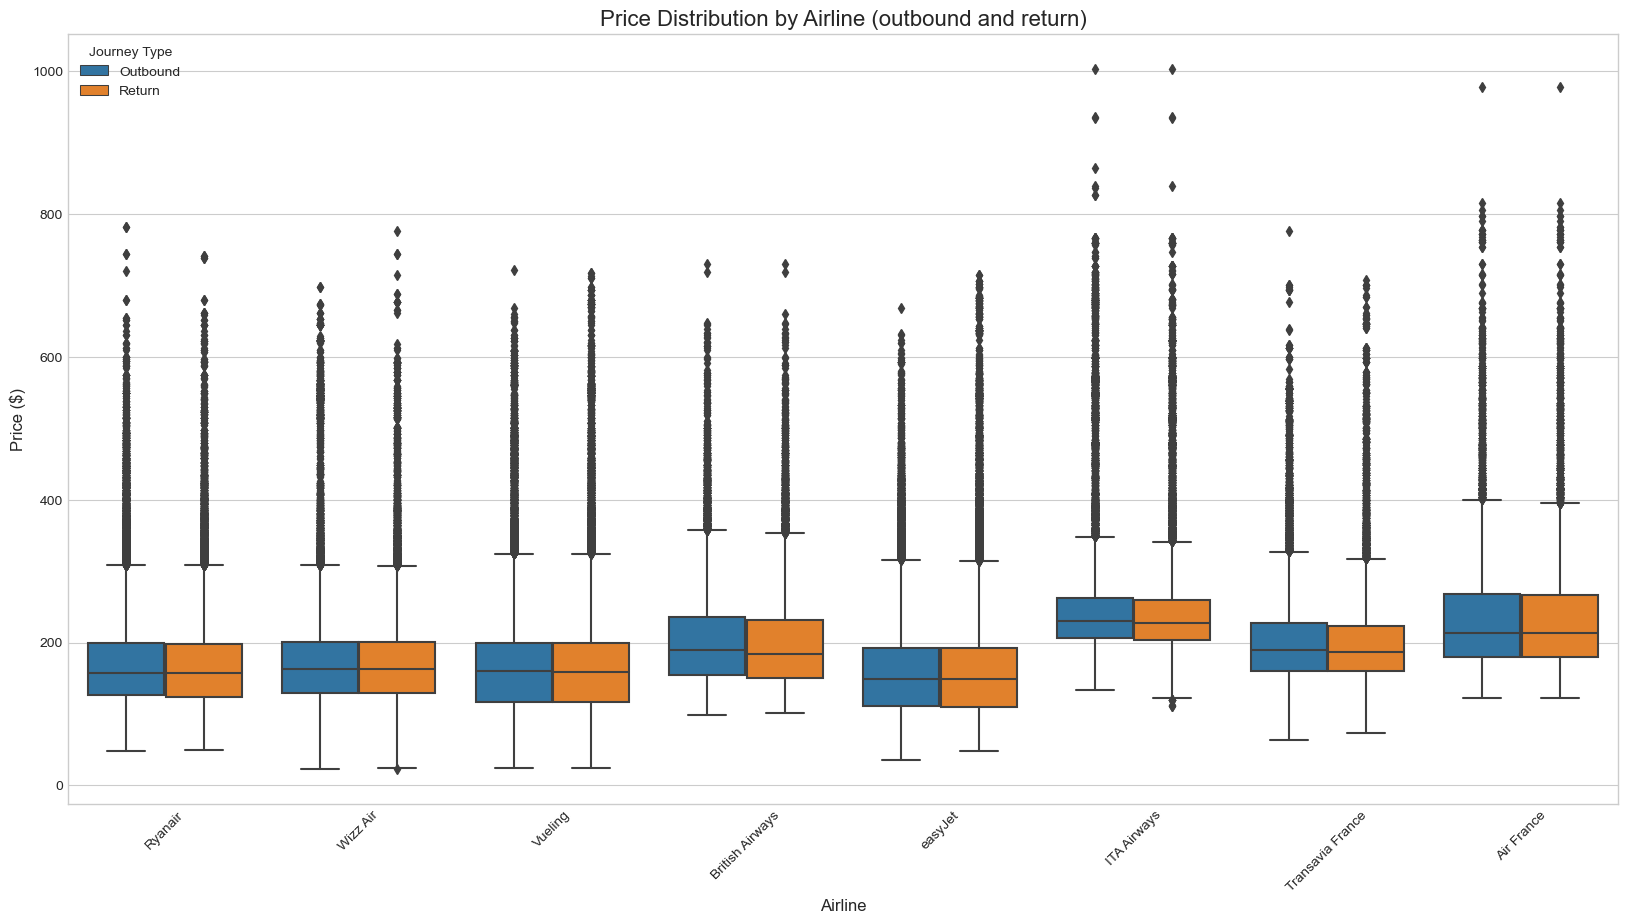

In [120]:
def price_per_airline(data):
    '''visualize dist of price per airway company (outbound and return)'''
    
    plt.figure(figsize=(20, 10))

    outbound_data = data[['price', 'to_dest_company']].copy()
    outbound_data['journey_type'] = 'Outbound'
    outbound_data.rename(columns={'to_dest_company': 'company'}, inplace=True)

    return_data = data[['price', 'return_company']].copy()
    return_data['journey_type'] = 'Return'
    return_data.rename(columns={'return_company': 'company'}, inplace=True)

    combined_data = pd.concat([outbound_data, return_data])

    # Get the top 10 most frequent airlines
    top_airlines = combined_data['company'].value_counts().nlargest(8).index.tolist()
    combined_data_filtered = combined_data[combined_data['company'].isin(top_airlines)]

    sns.boxplot(x='company', y='price', hue='journey_type', data=combined_data_filtered)
    plt.xlabel('Airline', fontsize=12)
    plt.ylabel('Price ($)', fontsize=12)
    plt.title('Price Distribution by Airline (outbound and return)', fontsize=16)
    plt.xticks(rotation=45)
    plt.legend(title='Journey Type')

price_per_airline(data)

now lets visualize the price per city (origin, destination anf total route)

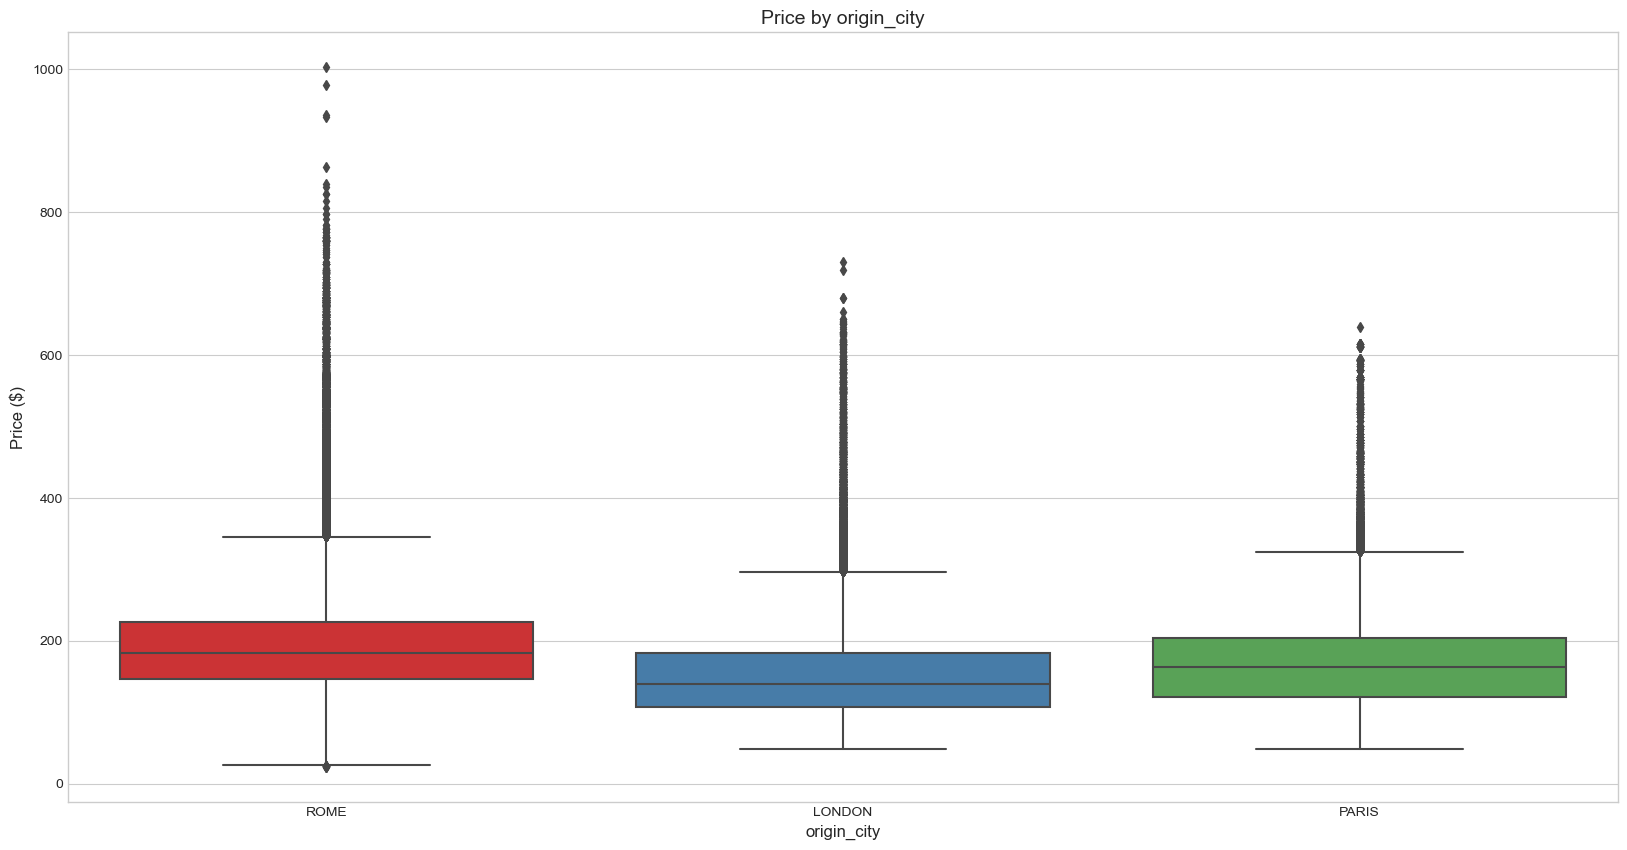

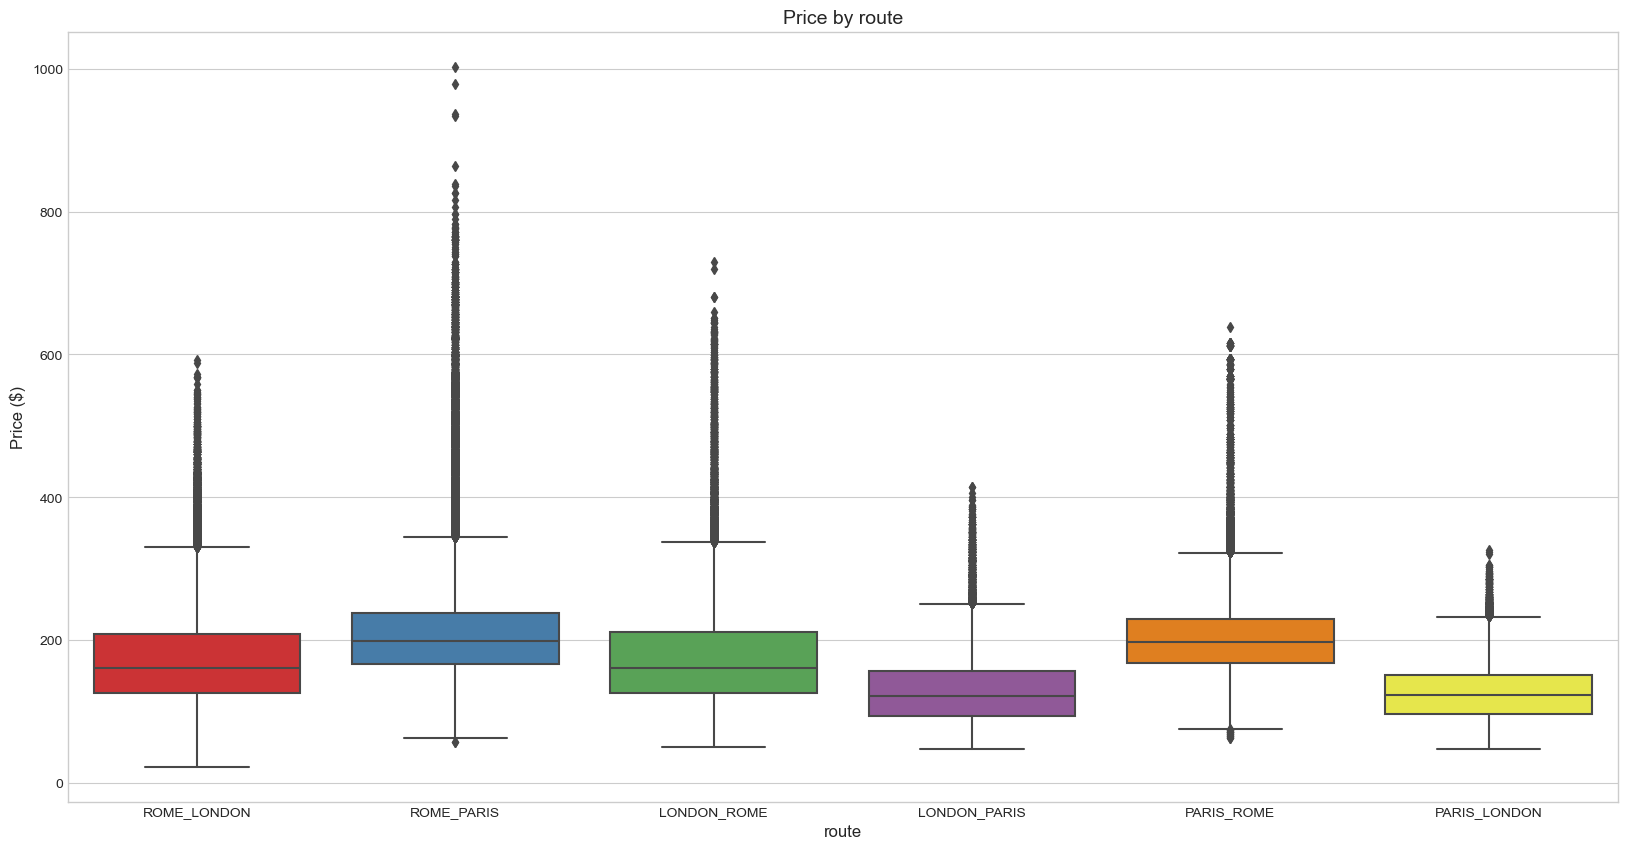

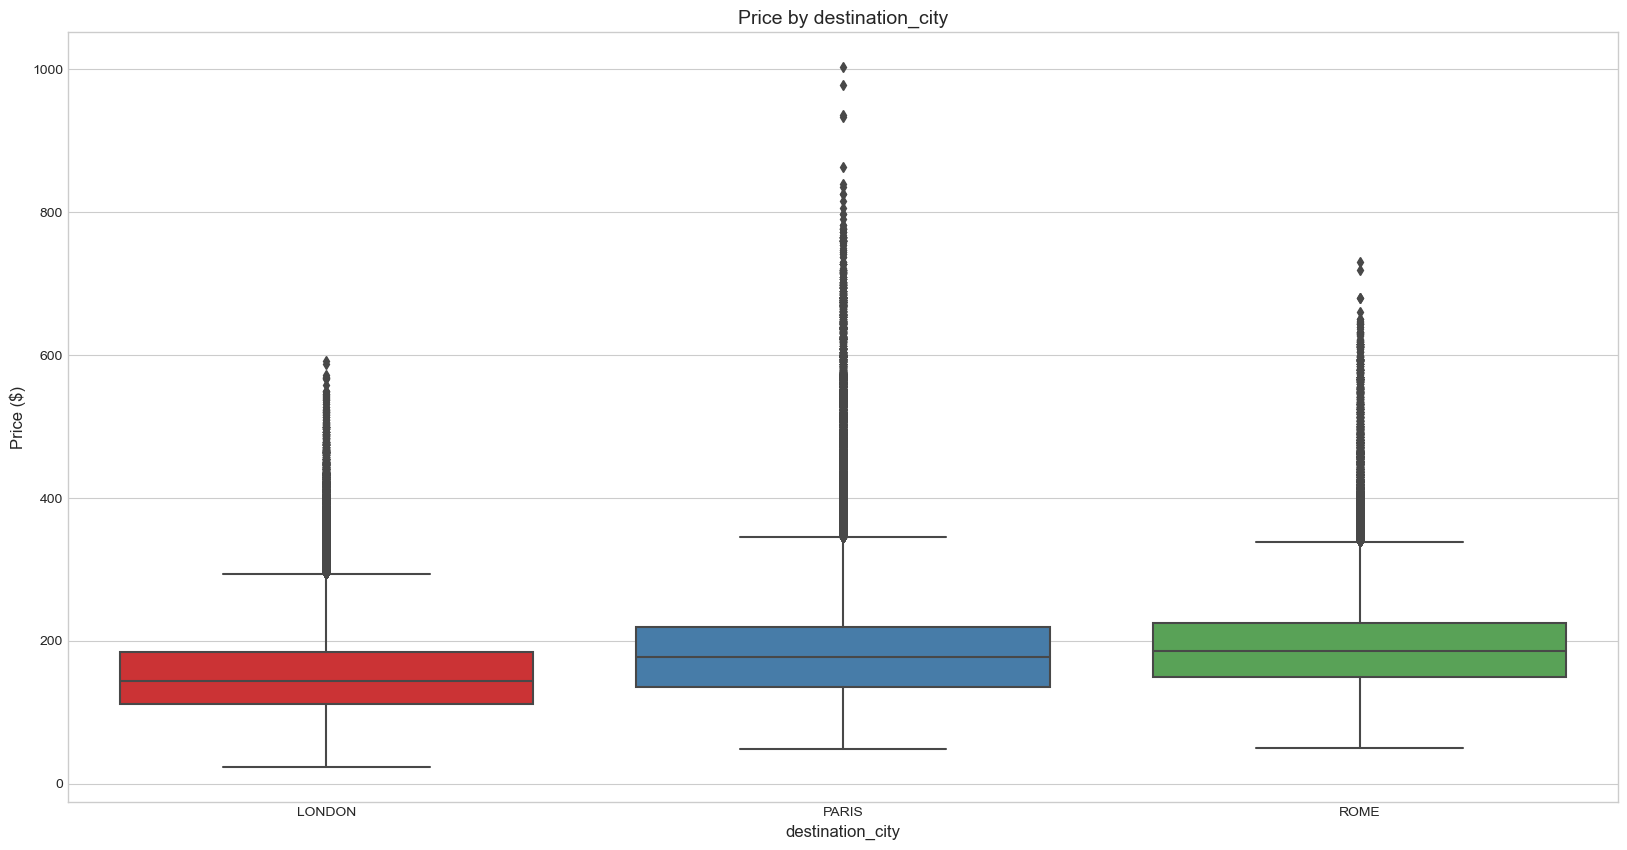

In [121]:
def price_per_feature(data, column: str):
    plt.figure(figsize=(20, 10))
    top_routes = data[column].value_counts().index.tolist()
    cities_data = data[data[column].isin(top_routes)]

    sns.boxplot(x= column, y='price', data=cities_data, palette='Set1')
    plt.title(f'Price by {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Price ($)', fontsize=12)
    
price_per_feature(data, 'origin_city')
price_per_feature(data, 'route')
price_per_feature(data, 'destination_city')

### Insights
- Rome is the most expensive distination to fly from and to, We can infer that the reason for the higher prices in Rome come from the fact that it is the most toured (trip with rome as destination is much more common then a trip with rome as outbound)
- the route of london to paris (and paris to london) is the cheapest, we can infer it because these cities are close to each other

### let check out the companies 

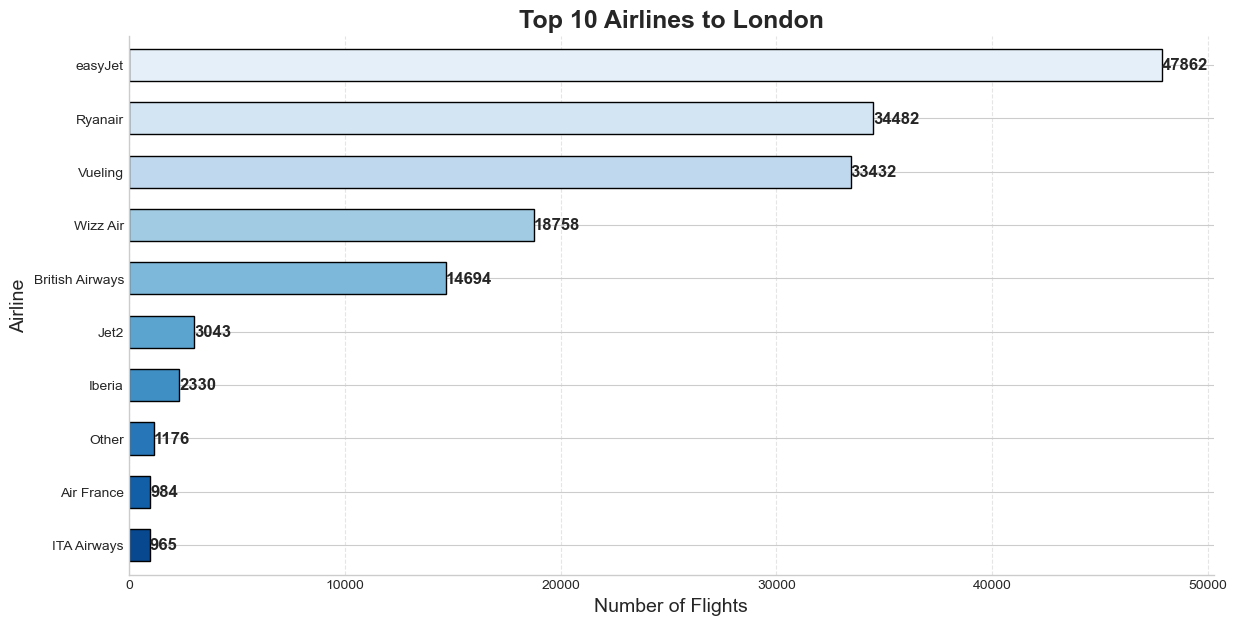

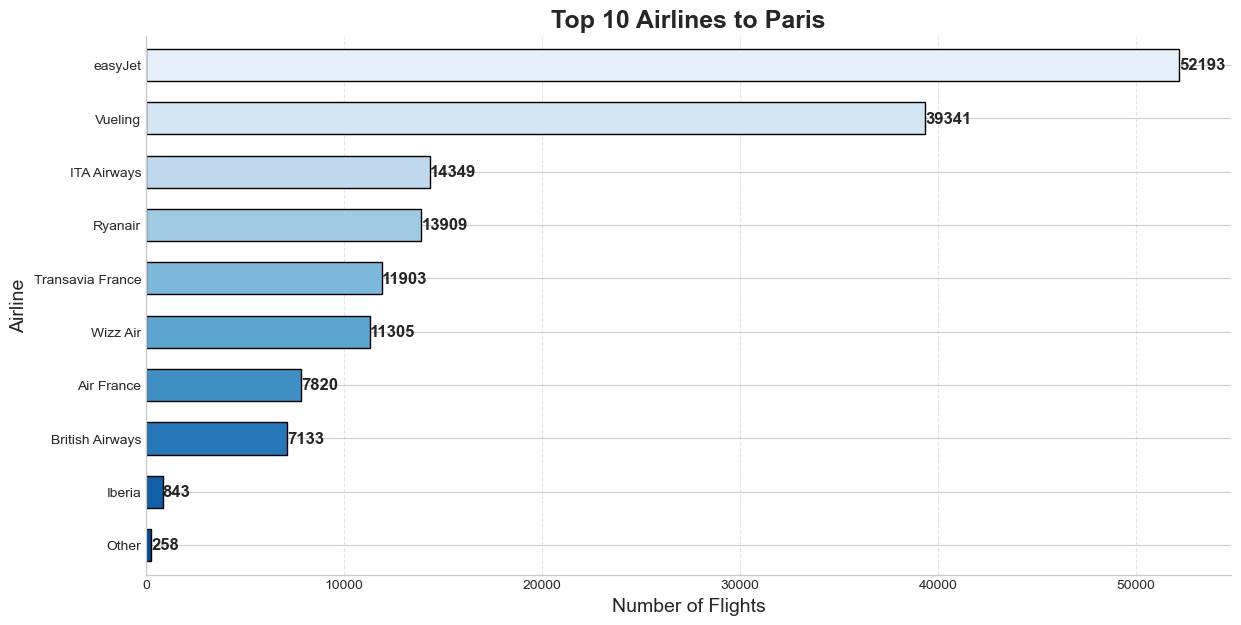

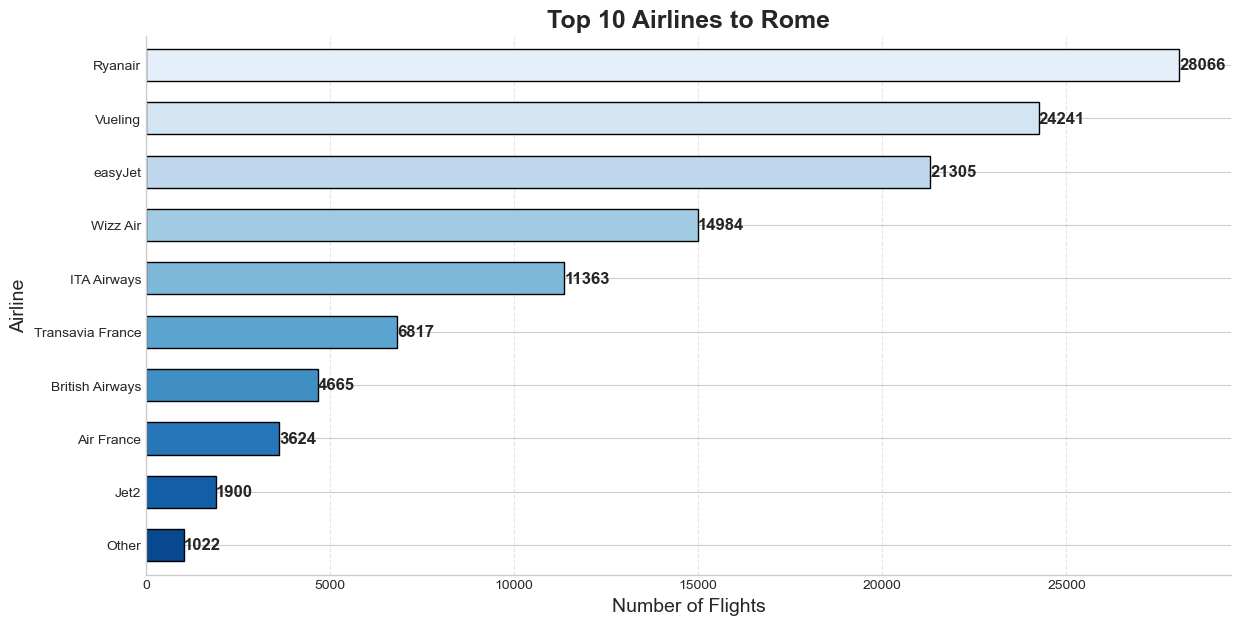

In [122]:
# Set seaborn style for better visualization
sns.set_style("whitegrid")

def top_airlines_per_city(data):
    flight_counts = data.groupby(["destination_city", "to_dest_company"]).size().unstack().fillna(0)

    # Get the top 5 airlines with the most flights for each destination
    london_flights = flight_counts.loc["LONDON"].nlargest(10)
    paris_flights = flight_counts.loc["PARIS"].nlargest(10)
    rome_flights = flight_counts.loc["ROME"].nlargest(10)

    # Plot the results
    flights_counts(london_flights, "London")
    flights_counts(paris_flights, "Paris")
    flights_counts(rome_flights, "Rome")

def flights_counts(dest_flight_counts, dest):
    fig, ax = plt.subplots(figsize=(14, 7))

    # Plot sorted bar chart
    bars = dest_flight_counts.sort_values(ascending=True).plot(
        kind="barh", 
        ax=ax, 
        edgecolor="black", 
        width=0.6,  # Reduce bar spacing
        color=sns.color_palette("Blues_r", len(dest_flight_counts))
    )

    # Improve aesthetics
    ax.set_title(f"Top 10 Airlines to {dest}", fontsize=18, fontweight="bold")
    ax.set_xlabel("Number of Flights", fontsize=14)
    ax.set_ylabel("Airline", fontsize=14)
    ax.grid(axis="x", linestyle="--", alpha=0.5)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    # Add value labels
    for bar in bars.patches:
        ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
                f'{int(bar.get_width())}', 
                ha='left', va='center', fontsize=12, fontweight="bold")

    plt.show()

# Call the function
top_airlines_per_city(data)


destination

c:\Users\Nadav\anaconda3\Lib\site-packages\seaborn\categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)
c:\Users\Nadav\anaconda3\Lib\site-packages\seaborn\categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)
c:\Users\Nadav\anaconda3\Lib\site-packages\seaborn\categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)
c:\Users\Nadav\anaconda3\Lib\site-packages\seaborn\categorical.py:645: FutureWarning:

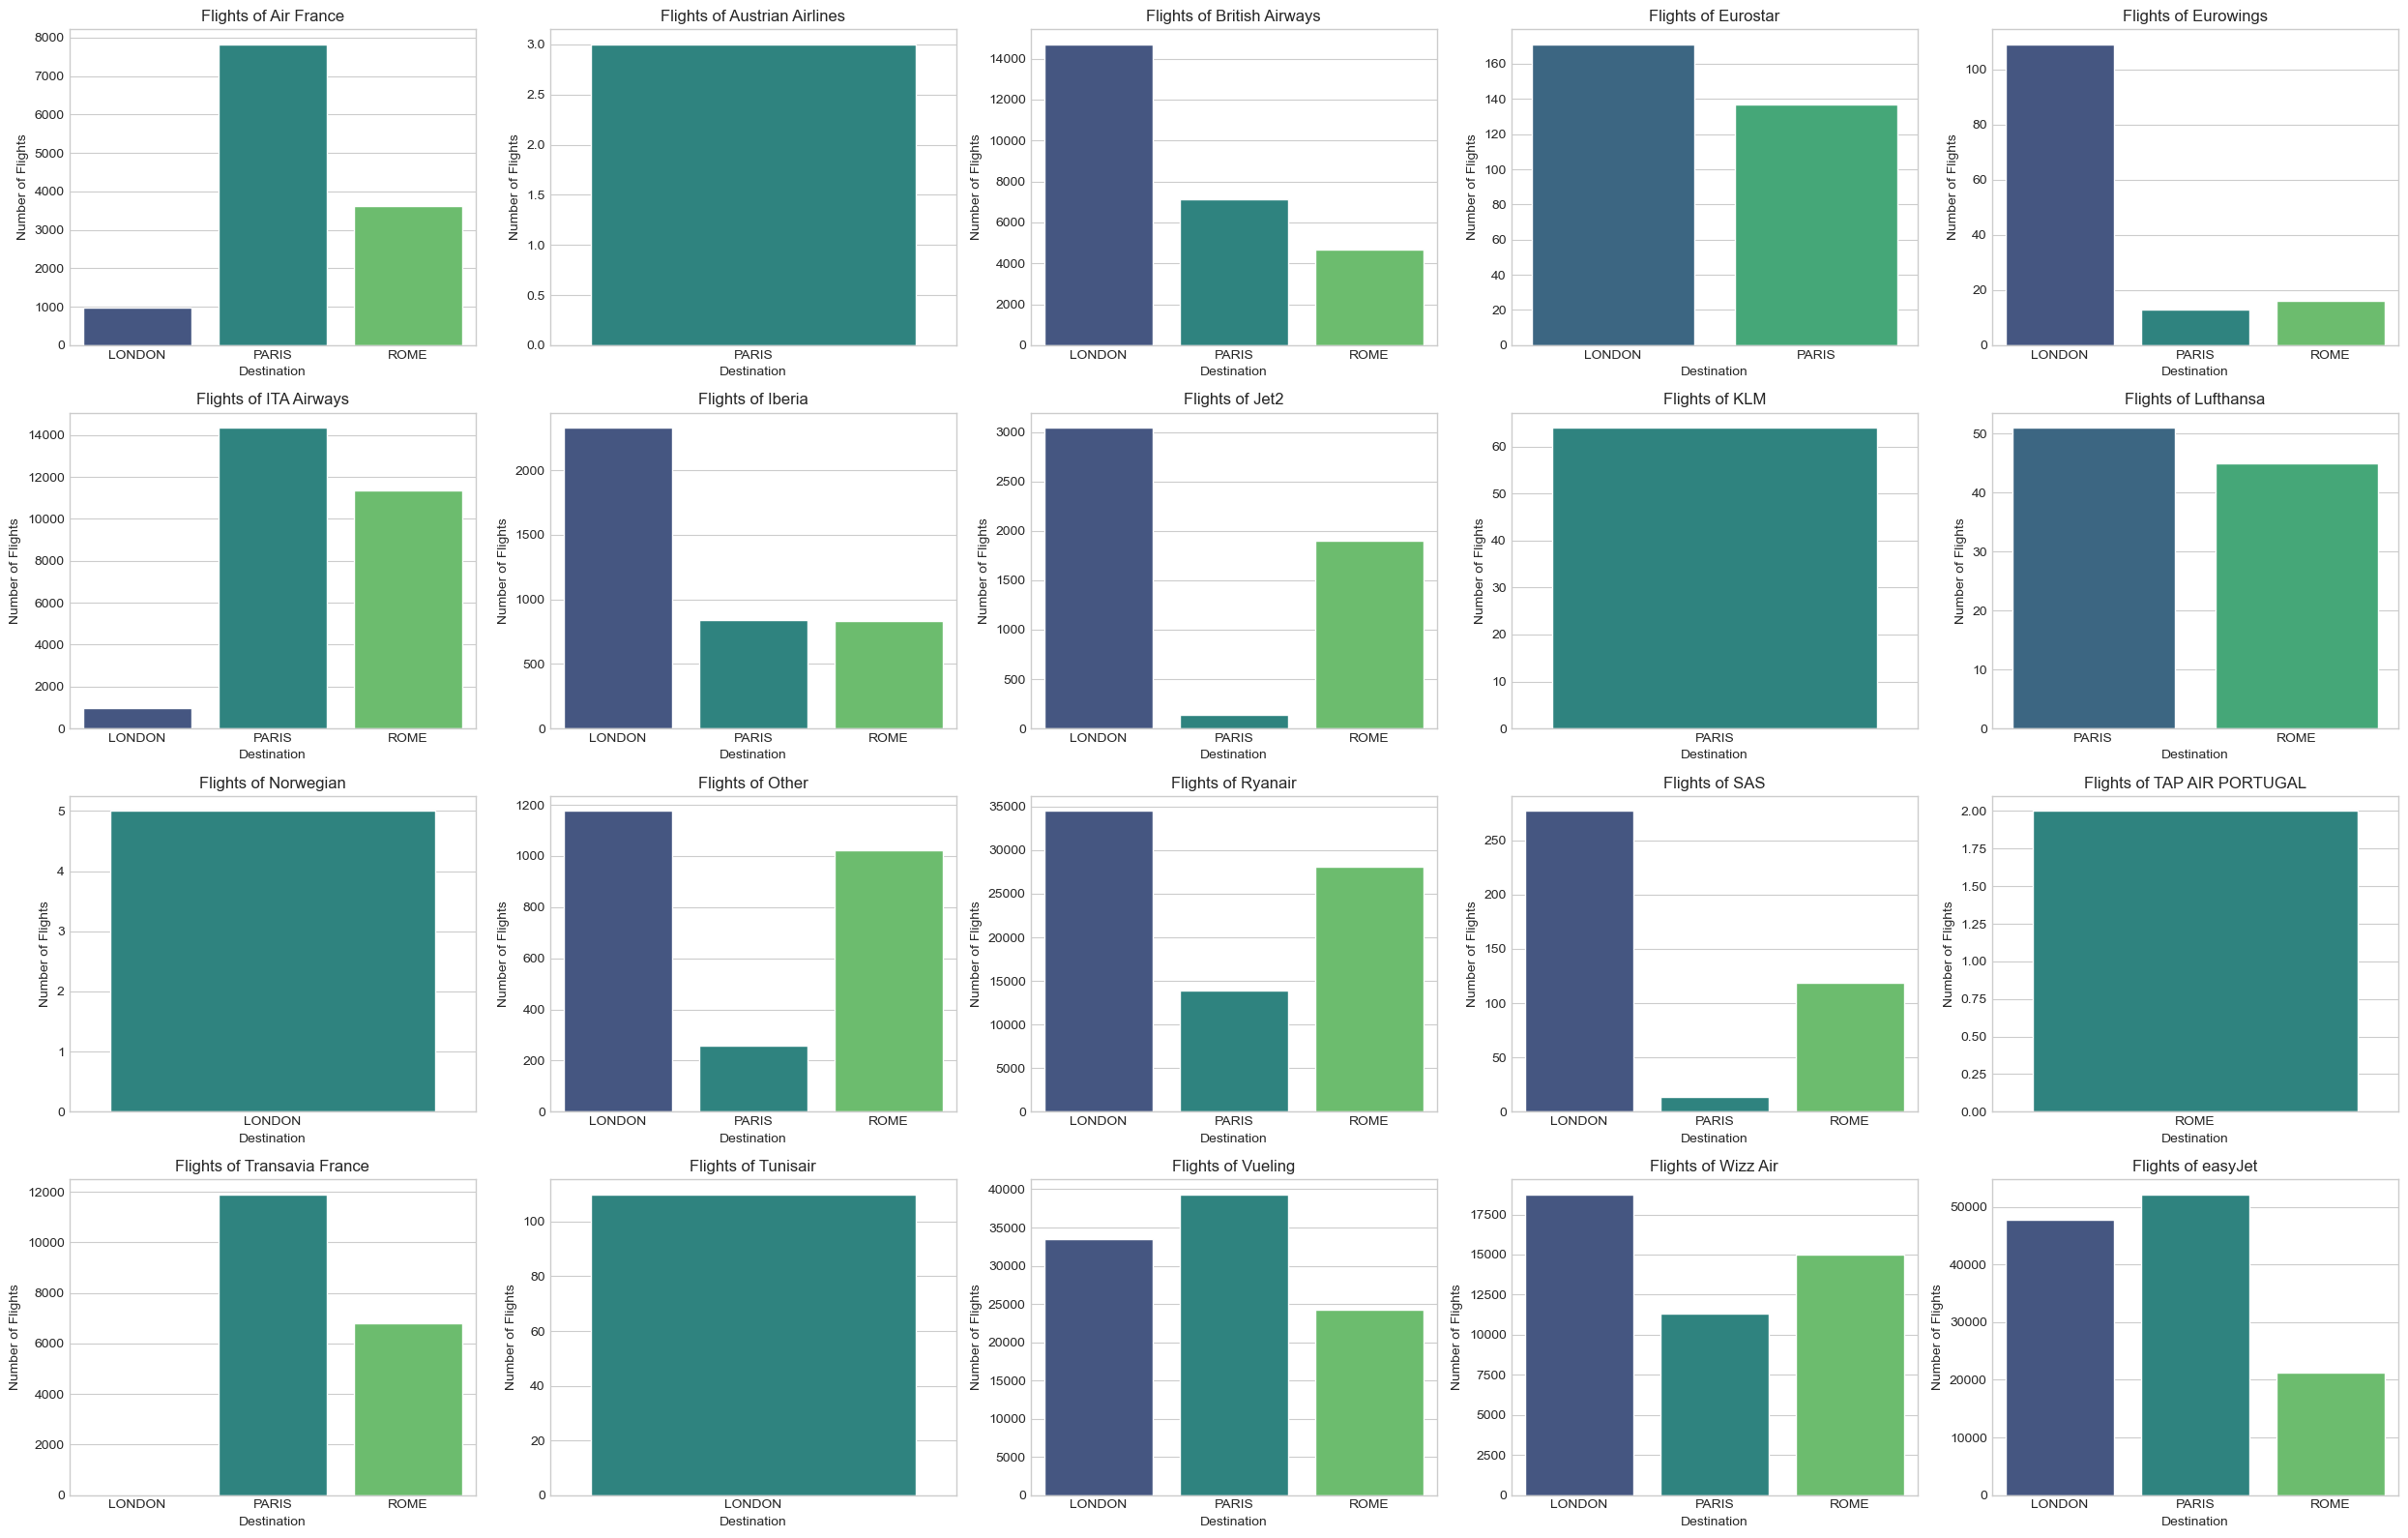

In [123]:
def flights_per_company(data):
    # Group data by flight company and destination, then count flights
    flight_counts = data.groupby(['to_dest_company', 'destination_city']).size().reset_index(name='count')

    # Get unique airlines
    airlines = flight_counts['to_dest_company'].unique()
    num_airlines = len(airlines)
    num_rows = int(np.ceil(num_airlines / 5))

    # Create subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=5, figsize=(25, 4 * num_rows))
    axes = axes.flatten()

    # Plot barplot for each airline
    for i, airline in enumerate(airlines):
        subset = flight_counts.loc[flight_counts['to_dest_company'] == airline].copy() # Use .loc and .copy()
        # Explicitly group the subset by destination city
        grouped_subset = subset.groupby('destination_city')['count'].sum().reset_index()
        sns.barplot(x='destination_city', y='count', data=grouped_subset, ax=axes[i], palette='viridis')
        axes[i].set_title(f'Flights of {airline}')
        axes[i].set_xlabel('Destination')
        axes[i].set_ylabel('Number of Flights')

    # Hide extra subplots
    for i in range(len(airlines), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

flights_per_company(data)

origin

c:\Users\Nadav\anaconda3\Lib\site-packages\seaborn\categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)
c:\Users\Nadav\anaconda3\Lib\site-packages\seaborn\categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)
c:\Users\Nadav\anaconda3\Lib\site-packages\seaborn\categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)
c:\Users\Nadav\anaconda3\Lib\site-packages\seaborn\categorical.py:645: FutureWarning:

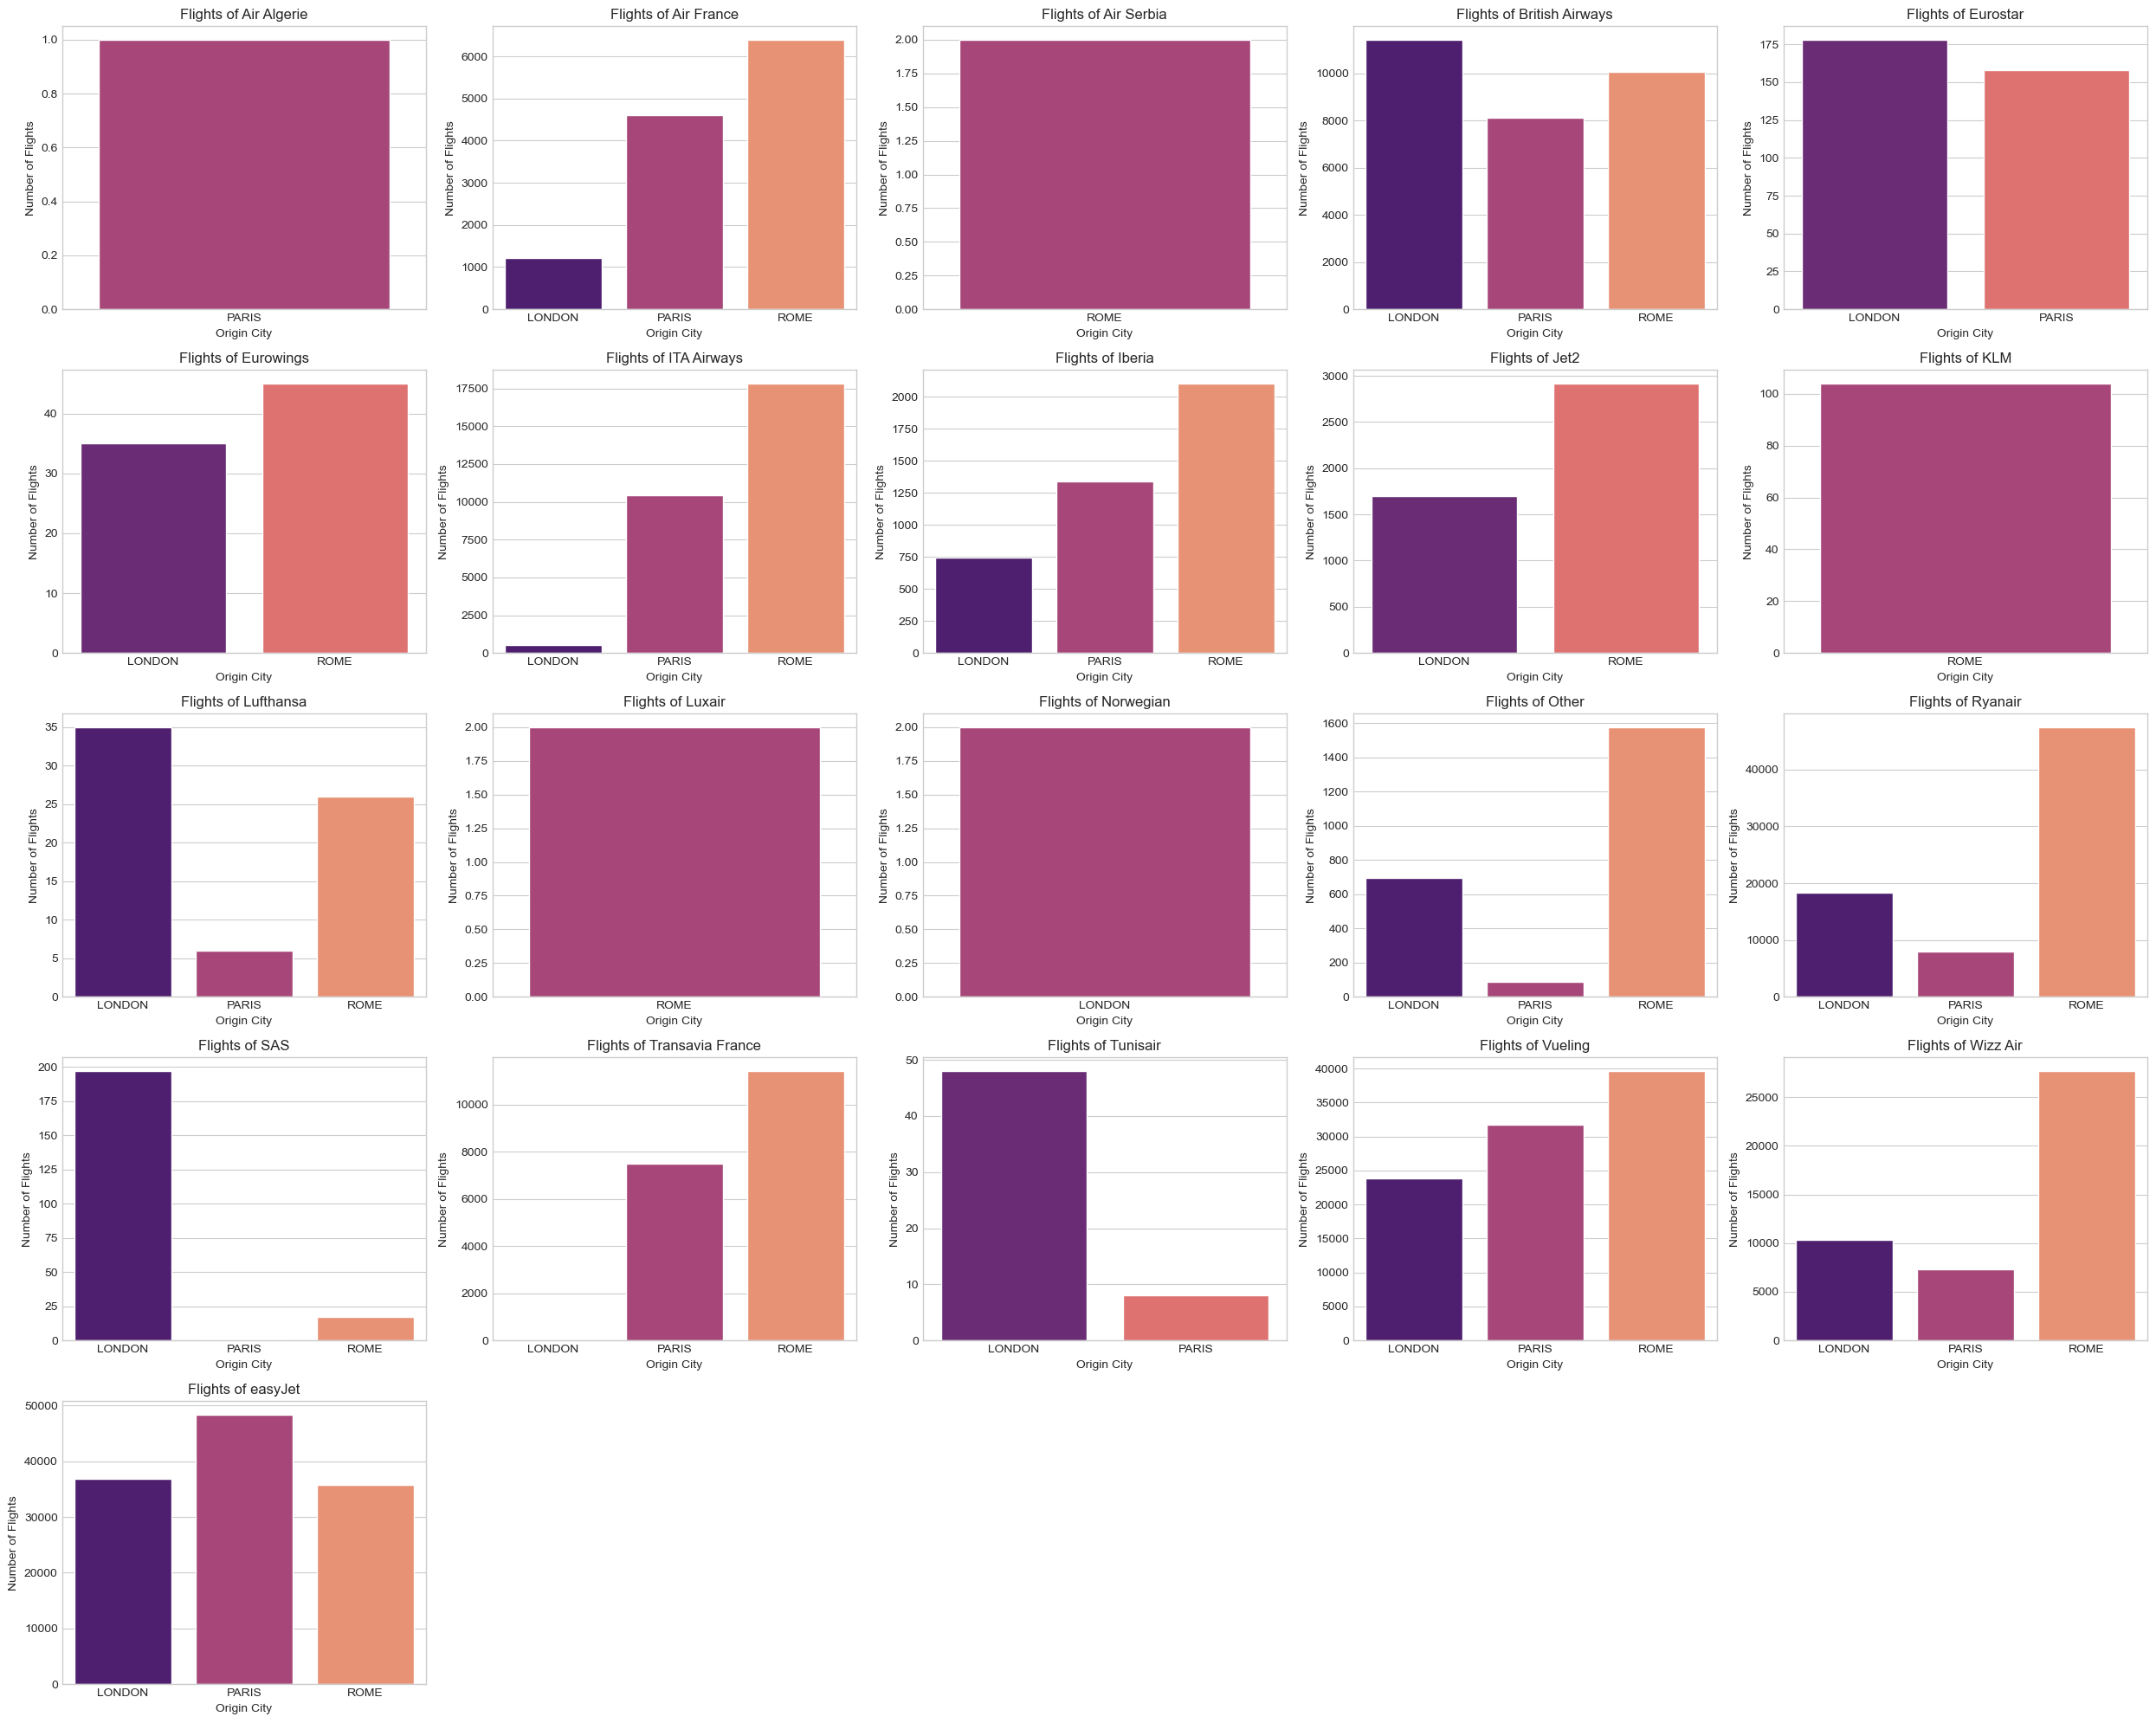

In [124]:
def flight_by_origin_city(data):
    # Group data by flight company and origin city, then count flights
    flight_counts = data.groupby(['return_company', 'origin_city']).size().reset_index(name='count')

    # Get unique airlines
    airlines = flight_counts['return_company'].unique()
    num_airlines = len(airlines)
    num_rows = int(np.ceil(num_airlines / 5))

    # Create subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=5, figsize=(25, 4 * num_rows))
    axes = axes.flatten()

    # Plot barplot for each airline
    for i, airline in enumerate(airlines):
        subset = flight_counts.loc[flight_counts['return_company'] == airline].copy() # Use .loc and .copy()
        # Explicitly group the subset by origin city
        grouped_subset = subset.groupby('origin_city')['count'].sum().reset_index()
        sns.barplot(x='origin_city', y='count', data=grouped_subset, ax=axes[i], palette='magma')
        axes[i].set_title(f'Flights of {airline}')
        axes[i].set_xlabel('Origin City')
        axes[i].set_ylabel('Number of Flights')

    # Hide extra subplots
    for i in range(len(airlines), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

flight_by_origin_city(data)

### Insights
- we can infer that there is a strong corelation between the airway company and the destination city

### Weekdats

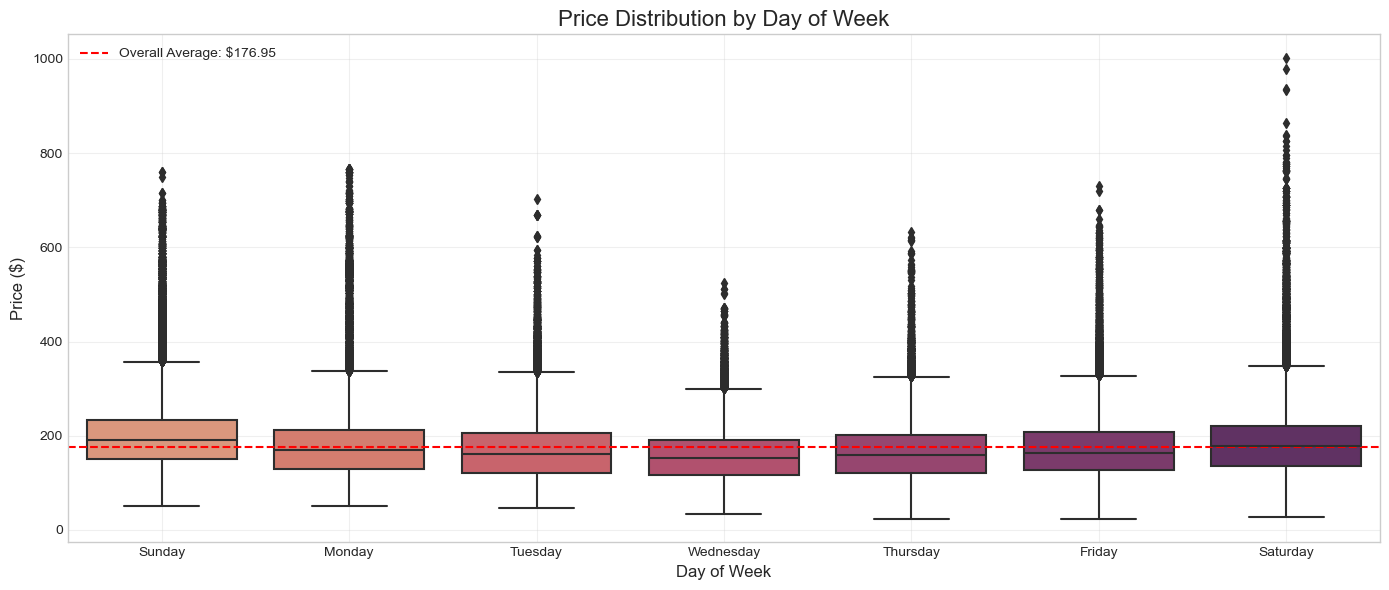

In [125]:
def prices_per_day(data):
    week_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
        
    fig = plt.figure(figsize=(14, 6))

    sns.boxplot(x='day_of_week', y='price', data=data, order=week_order, palette='flare')
    plt.title('Price Distribution by Day of Week', fontsize=16)
    plt.xlabel('Day of Week', fontsize=12)
    plt.ylabel('Price ($)', fontsize=12)
    plt.grid(True, alpha=0.3)

    # Add average line
    plt.axhline(y=data['price'].mean(), color='r', linestyle='--', 
                label=f'Overall Average: ${data["price"].mean():.2f}')
    plt.legend()

    plt.tight_layout()
prices_per_day(data)

### Insights
- on weekend (chrisitan: sunday, saturday) the prices are higher then in the middle of the week (wednesday)
- in saturday the mean is equal to the median and has the largest outlier (prob the most popular so the prices are normlized and has the largest supply)

### Layovers

#### outbound layover

,Mean Layover,Median Layover,Min Layover,Max Layover,Layover Std Dev
destination_city,,,,,
LONDON,5.3500,0.0000,0,1335,37.1400
PARIS,5.4600,0.0000,0,1495,42.5900
ROME,8.3300,0.0000,0,1245,45.4800


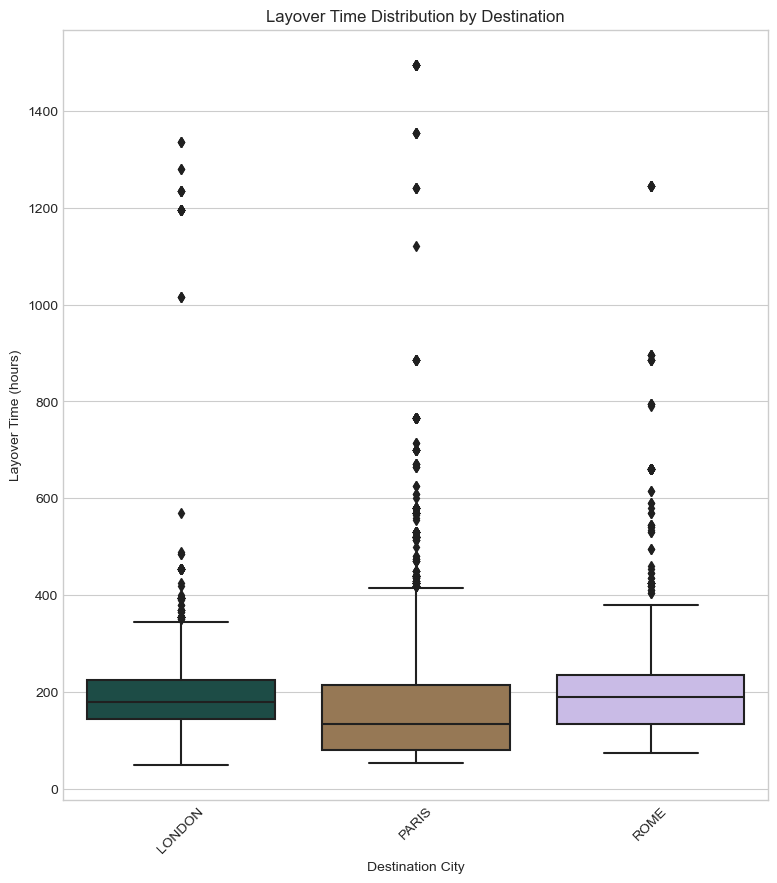

In [126]:
def plot_layover_time(data):
    layover_data = data[data['layover']== True]
    layover_data = layover_data[layover_data['layover_time'] > 0]
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 2, 1)
    sns.boxplot(x='destination_city', y='layover_time', data=layover_data, palette='cubehelix')
    plt.title('Layover Time Distribution by Destination')
    plt.xlabel('Destination City')
    plt.ylabel('Layover Time (hours)')
    plt.xticks(rotation=45)

def group_destcity_layovertime(data):
    # Calculate summary statistics
    display(data.groupby('destination_city')['layover_time'].agg([
        ('Mean Layover', 'mean'),
        ('Median Layover', 'median'),
        ('Min Layover', 'min'),
        ('Max Layover', 'max'),
        ('Layover Std Dev', 'std')
    ]).round(2))

def layover_time(data):
    plot_layover_time(data)
    group_destcity_layovertime(data)
    
layover_time(data)

if there is a layover, price dist over time of layover per dest

,Mean Layover,Median Layover,Min Layover,Max Layover,Layover Std Dev
destination_city,,,,,
LONDON,5.7300,0.0000,0,1245,38.1000
PARIS,4.8200,0.0000,0,1495,35.5800
ROME,6.7700,0.0000,0,1495,44.0000


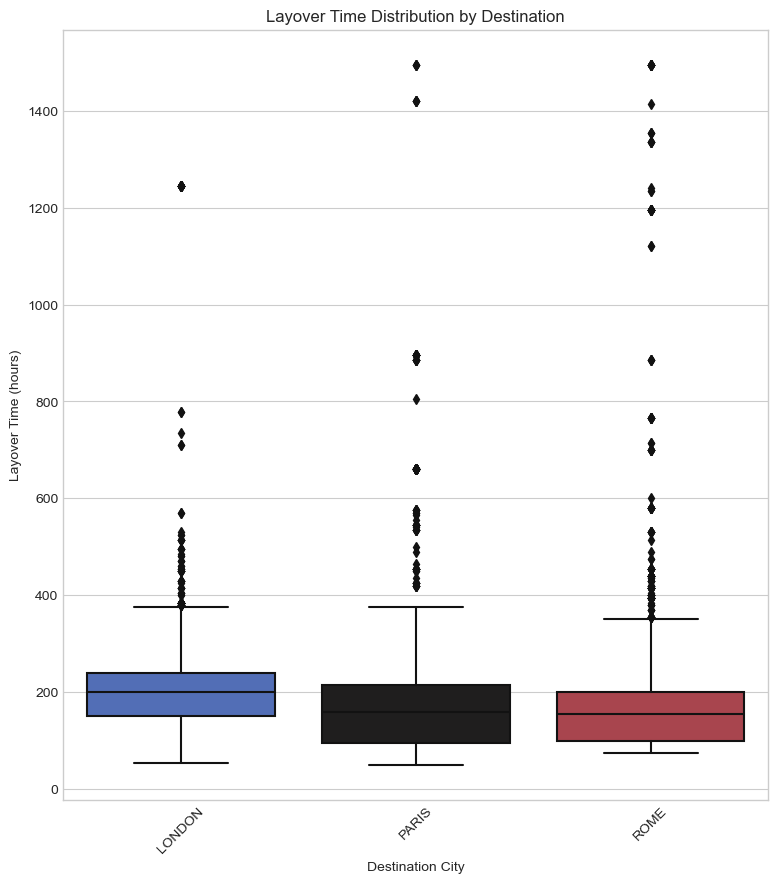

In [127]:
def plot_layover_return_time(data):
    layover_data = data[data['layover']== True]
    layover_data = layover_data[layover_data['return_layover_time'] > 0]
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 2, 1)
    sns.boxplot(x='destination_city', y='return_layover_time', data=layover_data, palette='icefire')
    plt.title('Layover Time Distribution by Destination')
    plt.xlabel('Destination City')
    plt.ylabel('Layover Time (hours)')
    plt.xticks(rotation=45)


def group_destcity_return_layovertime(data):
    # Calculate summary statistics
    display(data.groupby('destination_city')['return_layover_time'].agg([
        ('Mean Layover', 'mean'),
        ('Median Layover', 'median'),
        ('Min Layover', 'min'),
        ('Max Layover', 'max'),
        ('Layover Std Dev', 'std')
    ]).round(2))

def return_layover_time(data):
    plot_layover_return_time(data)
    group_destcity_return_layovertime(data)
    
return_layover_time(data)

departure airport per city price influance

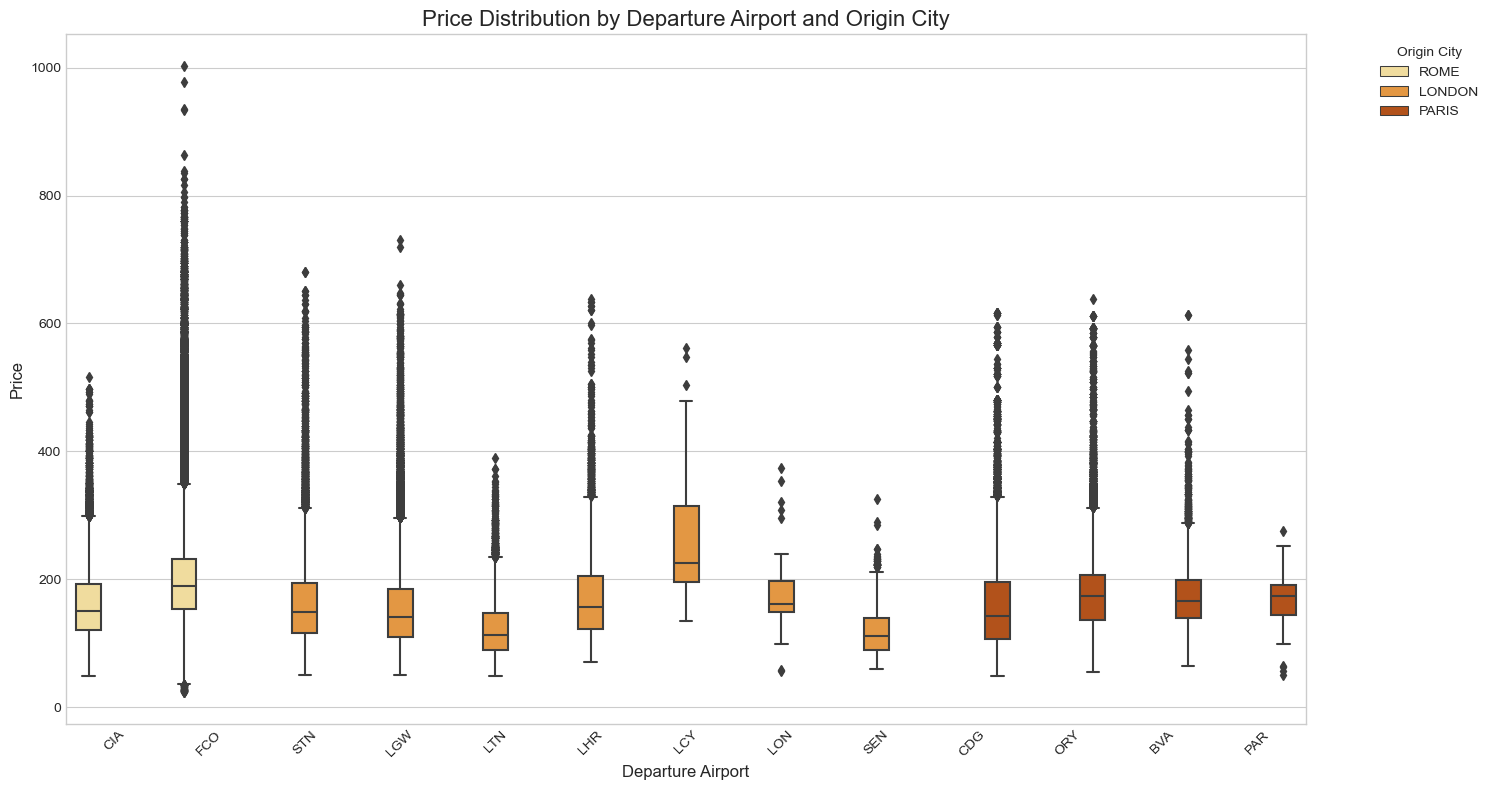

In [128]:
def price_per_deptair_origcity(data):
    plt.figure(figsize=(15, 8))
        
    # Create a box plot to show price distribution by departure airport for each origin city
    sns.boxplot(x='departure_airport', y='price', hue='origin_city', data=data ,palette='YlOrBr')

    plt.title('Price Distribution by Departure Airport and Origin City', fontsize=16)
    plt.xlabel('Departure Airport', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Origin City', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

def group_origincity_deptairport(data):
    # Calculate summary statistics
    data.groupby(['origin_city', 'departure_airport'])['price'].agg([
        ('Mean Price', 'mean'),
        ('Median Price', 'median'),
        ('Min Price', 'min'),
        ('Max Price', 'max'),
        ('Price Std Dev', 'std'),
        ('Number of Flights', 'count')
    ]).round(2)

price_per_deptair_origcity(data)
group_origincity_deptairport(data)

c:\Users\Nadav\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


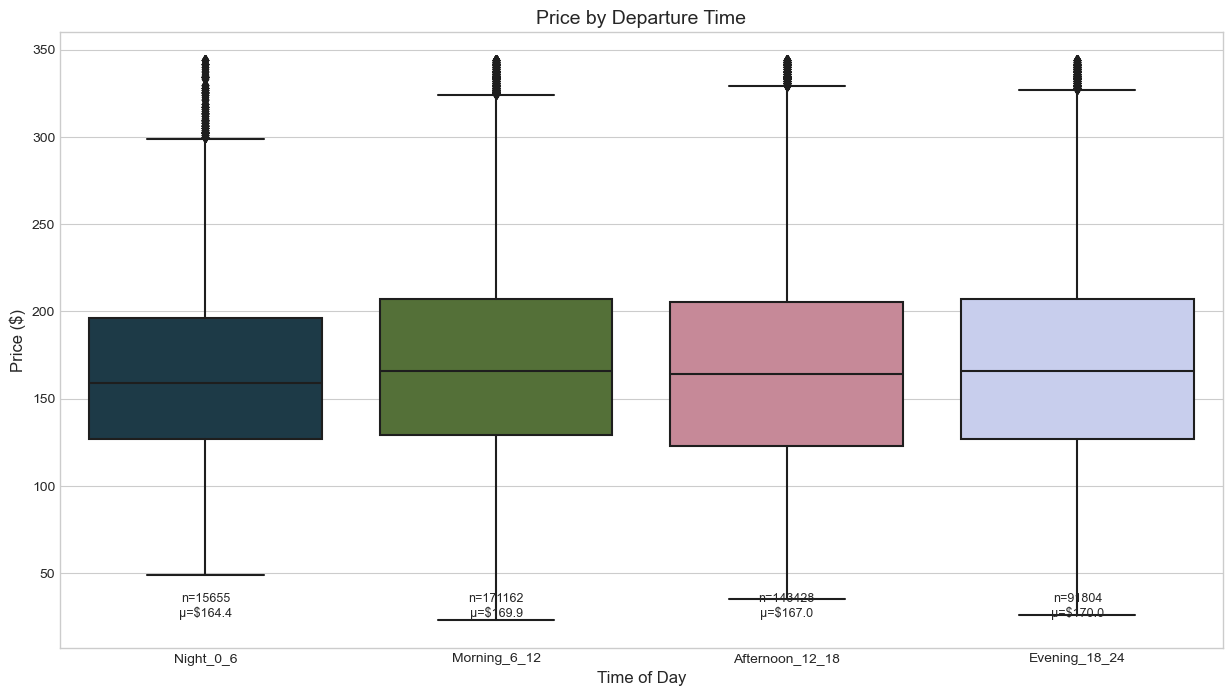

In [176]:
plt.figure(figsize=(15, 8))

# Create time categories
data['time_category'] = pd.cut(
    data['departure_hour'], 
    bins=[0, 6, 12, 18, 24],
    labels=['Night_0_6', 'Morning_6_12', 'Afternoon_12_18', 'Evening_18_24']
)

sns.boxplot(x='time_category', y='price', data=data, palette='cubehelix')
plt.title('Price by Departure Time', fontsize=14)
plt.xlabel('Time of Day', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)

# Add count and mean annotations
for i, category in enumerate(data['time_category'].cat.categories):
    count = data[data['time_category'] == category].shape[0]
    mean = data[data['time_category'] == category]['price'].mean()
    plt.annotate(f'n={count}\nμ=${mean:.1f}', 
                        xy=(i, data['price'].min()), 
                        ha='center', va='bottom', fontsize=9)

evening and afternoon almost identical

### Remove the outlier (Tukey method: 1.5*IQR)

In [130]:
def remove_route_outliers(group):
    Q1 = group['price'].quantile(0.25)
    Q3 = group['price'].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return group[(group['price'] >= lower_bound) & 
                        (group['price'] <= upper_bound)]

#### Lets visualize before and after removing the outlier (price over route)

C:\Users\Nadav\AppData\Local\Temp\ipykernel_26456\2674912080.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_cleaned = data.groupby('route', group_keys=False).apply(remove_route_outliers).reset_index(drop=True)


Original DataFrame size: 436873
Cleaned DataFrame size: 422049
Number of outliers removed: 14824
Percentage of data removed: 3.39%

Price Statistics - Original Data:
              Mean Price  Median Price  Min Price  Max Price  Price Std Dev  \
route                                                                         
LONDON_PARIS    129.9500      122.0000    48.0000   414.0000        46.9000   
LONDON_ROME     177.3800      161.0000    50.0000   730.0000        74.7800   
PARIS_LONDON    126.4200      122.7400    48.0000   326.0000        38.5300   
PARIS_ROME      204.1200      197.0000    63.0000   639.0000        54.4000   
ROME_LONDON     172.9400      160.5900    23.0000   592.0000        66.1900   
ROME_PARIS      216.4800      199.0000    57.0000  1003.0000        82.3800   

              Total Flights  
route                        
LONDON_PARIS          54515  
LONDON_ROME           51640  
PARIS_LONDON          60316  
PARIS_ROME            67360  
ROME_LONDON          

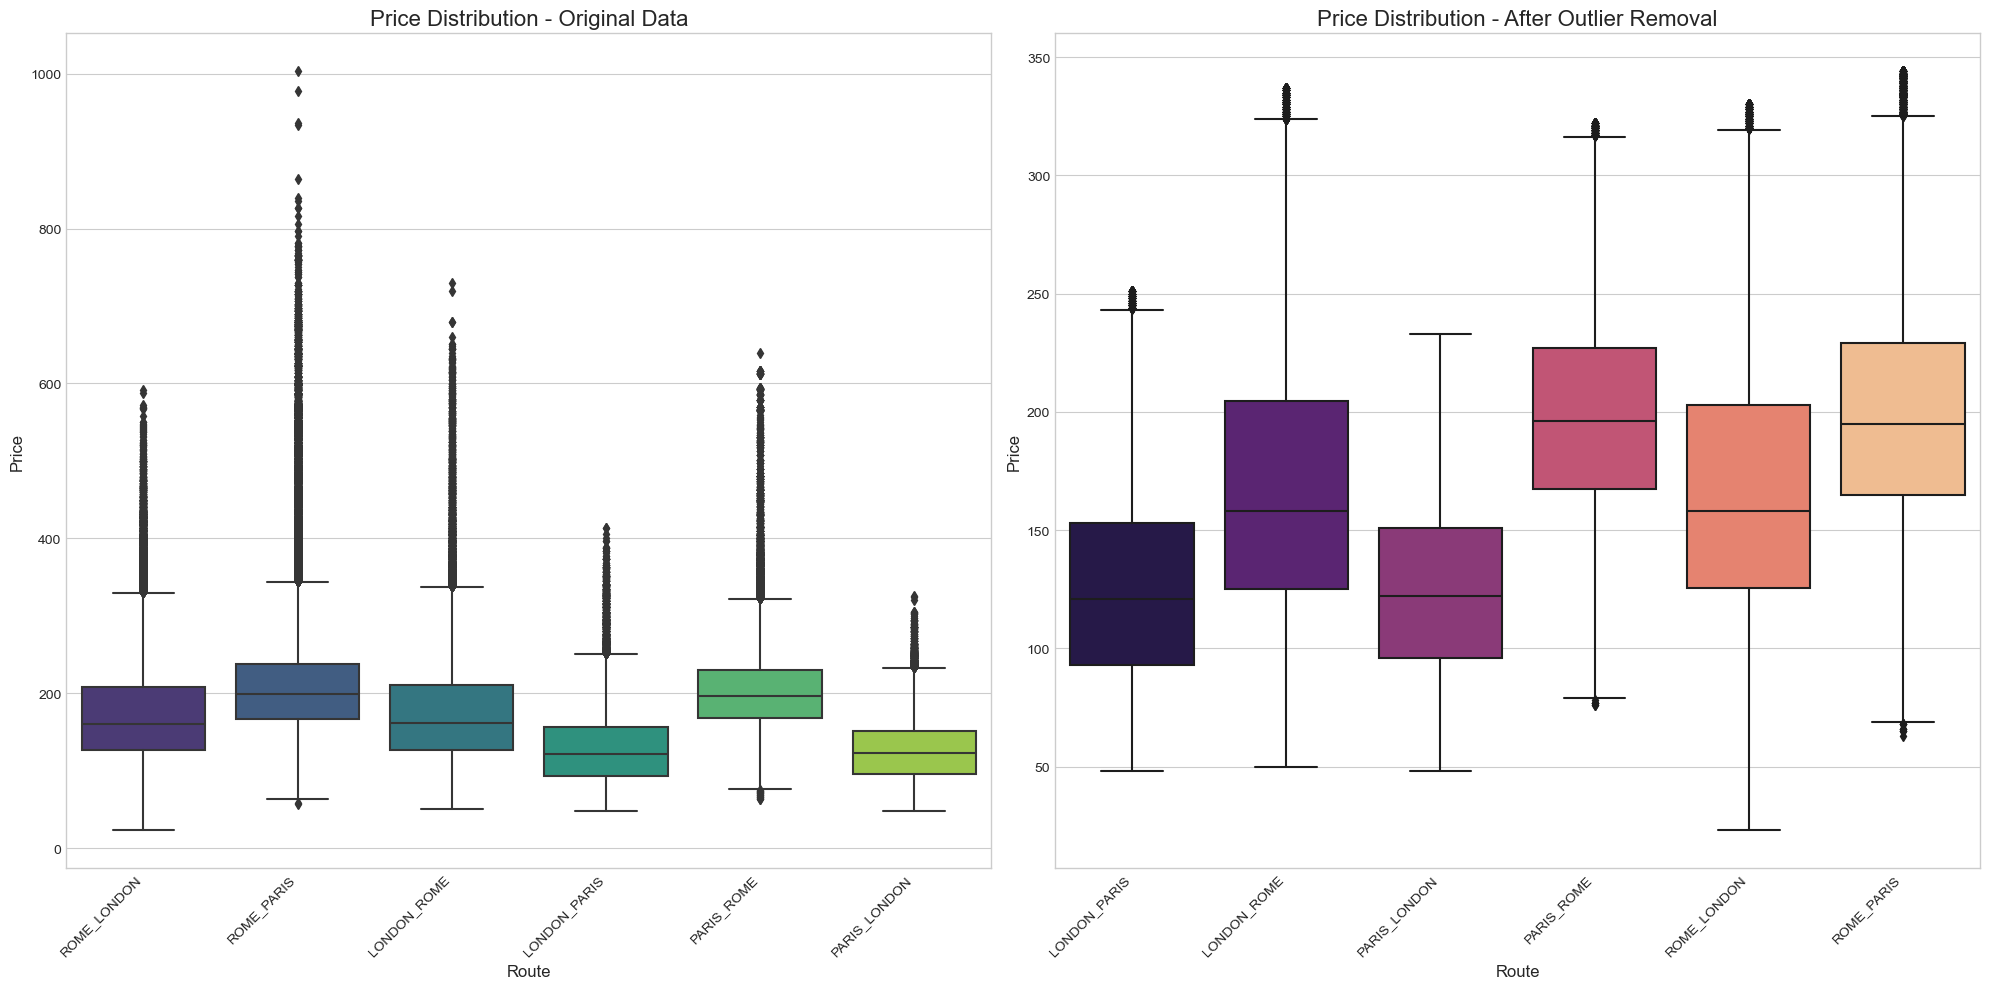

In [131]:
# Group by route and remove outliers
data_cleaned = data.groupby('route', group_keys=False).apply(remove_route_outliers).reset_index(drop=True)

# Print removal statistics
original_count = len(data)
cleaned_count = len(data_cleaned)
removed_count = original_count - cleaned_count

print(f"Original DataFrame size: {original_count}")
print(f"Cleaned DataFrame size: {cleaned_count}")
print(f"Number of outliers removed: {removed_count}")
print(f"Percentage of data removed: {removed_count/original_count*100:.2f}%")

# Set up the figure with two subplots
plt.figure(figsize=(20, 10))

# Original Data Distribution
plt.subplot(1, 2, 1)
sns.boxplot(x='route', y='price', data=data, palette='viridis')
plt.title('Price Distribution - Original Data', fontsize=16)
plt.xlabel('Route', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Cleaned Data Distribution
plt.subplot(1, 2, 2)
sns.boxplot(x='route', y='price', data=data_cleaned, palette='magma')
plt.title('Price Distribution - After Outlier Removal', fontsize=16)
plt.xlabel('Route', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Adjust layout and save
plt.tight_layout()

# Additional statistical summary
print("\nPrice Statistics - Original Data:")
original_stats = data.groupby('route')['price'].agg([
    ('Mean Price', 'mean'),
    ('Median Price', 'median'),
    ('Min Price', 'min'),
    ('Max Price', 'max'),
    ('Price Std Dev', 'std'),
    ('Total Flights', 'count')
]).round(2)
print(original_stats)

print("\nPrice Statistics - Cleaned Data:")
cleaned_stats = data_cleaned.groupby('route')['price'].agg([
    ('Mean Price', 'mean'),
    ('Median Price', 'median'),
    ('Min Price', 'min'),
    ('Max Price', 'max'),
    ('Price Std Dev', 'std'),
    ('Total Flights', 'count')
]).round(2)
print(cleaned_stats)
data = data_cleaned

### Pairplot

c:\Users\Nadav\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Nadav\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Nadav\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Nadav\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

<Figure size 2000x1600 with 0 Axes>

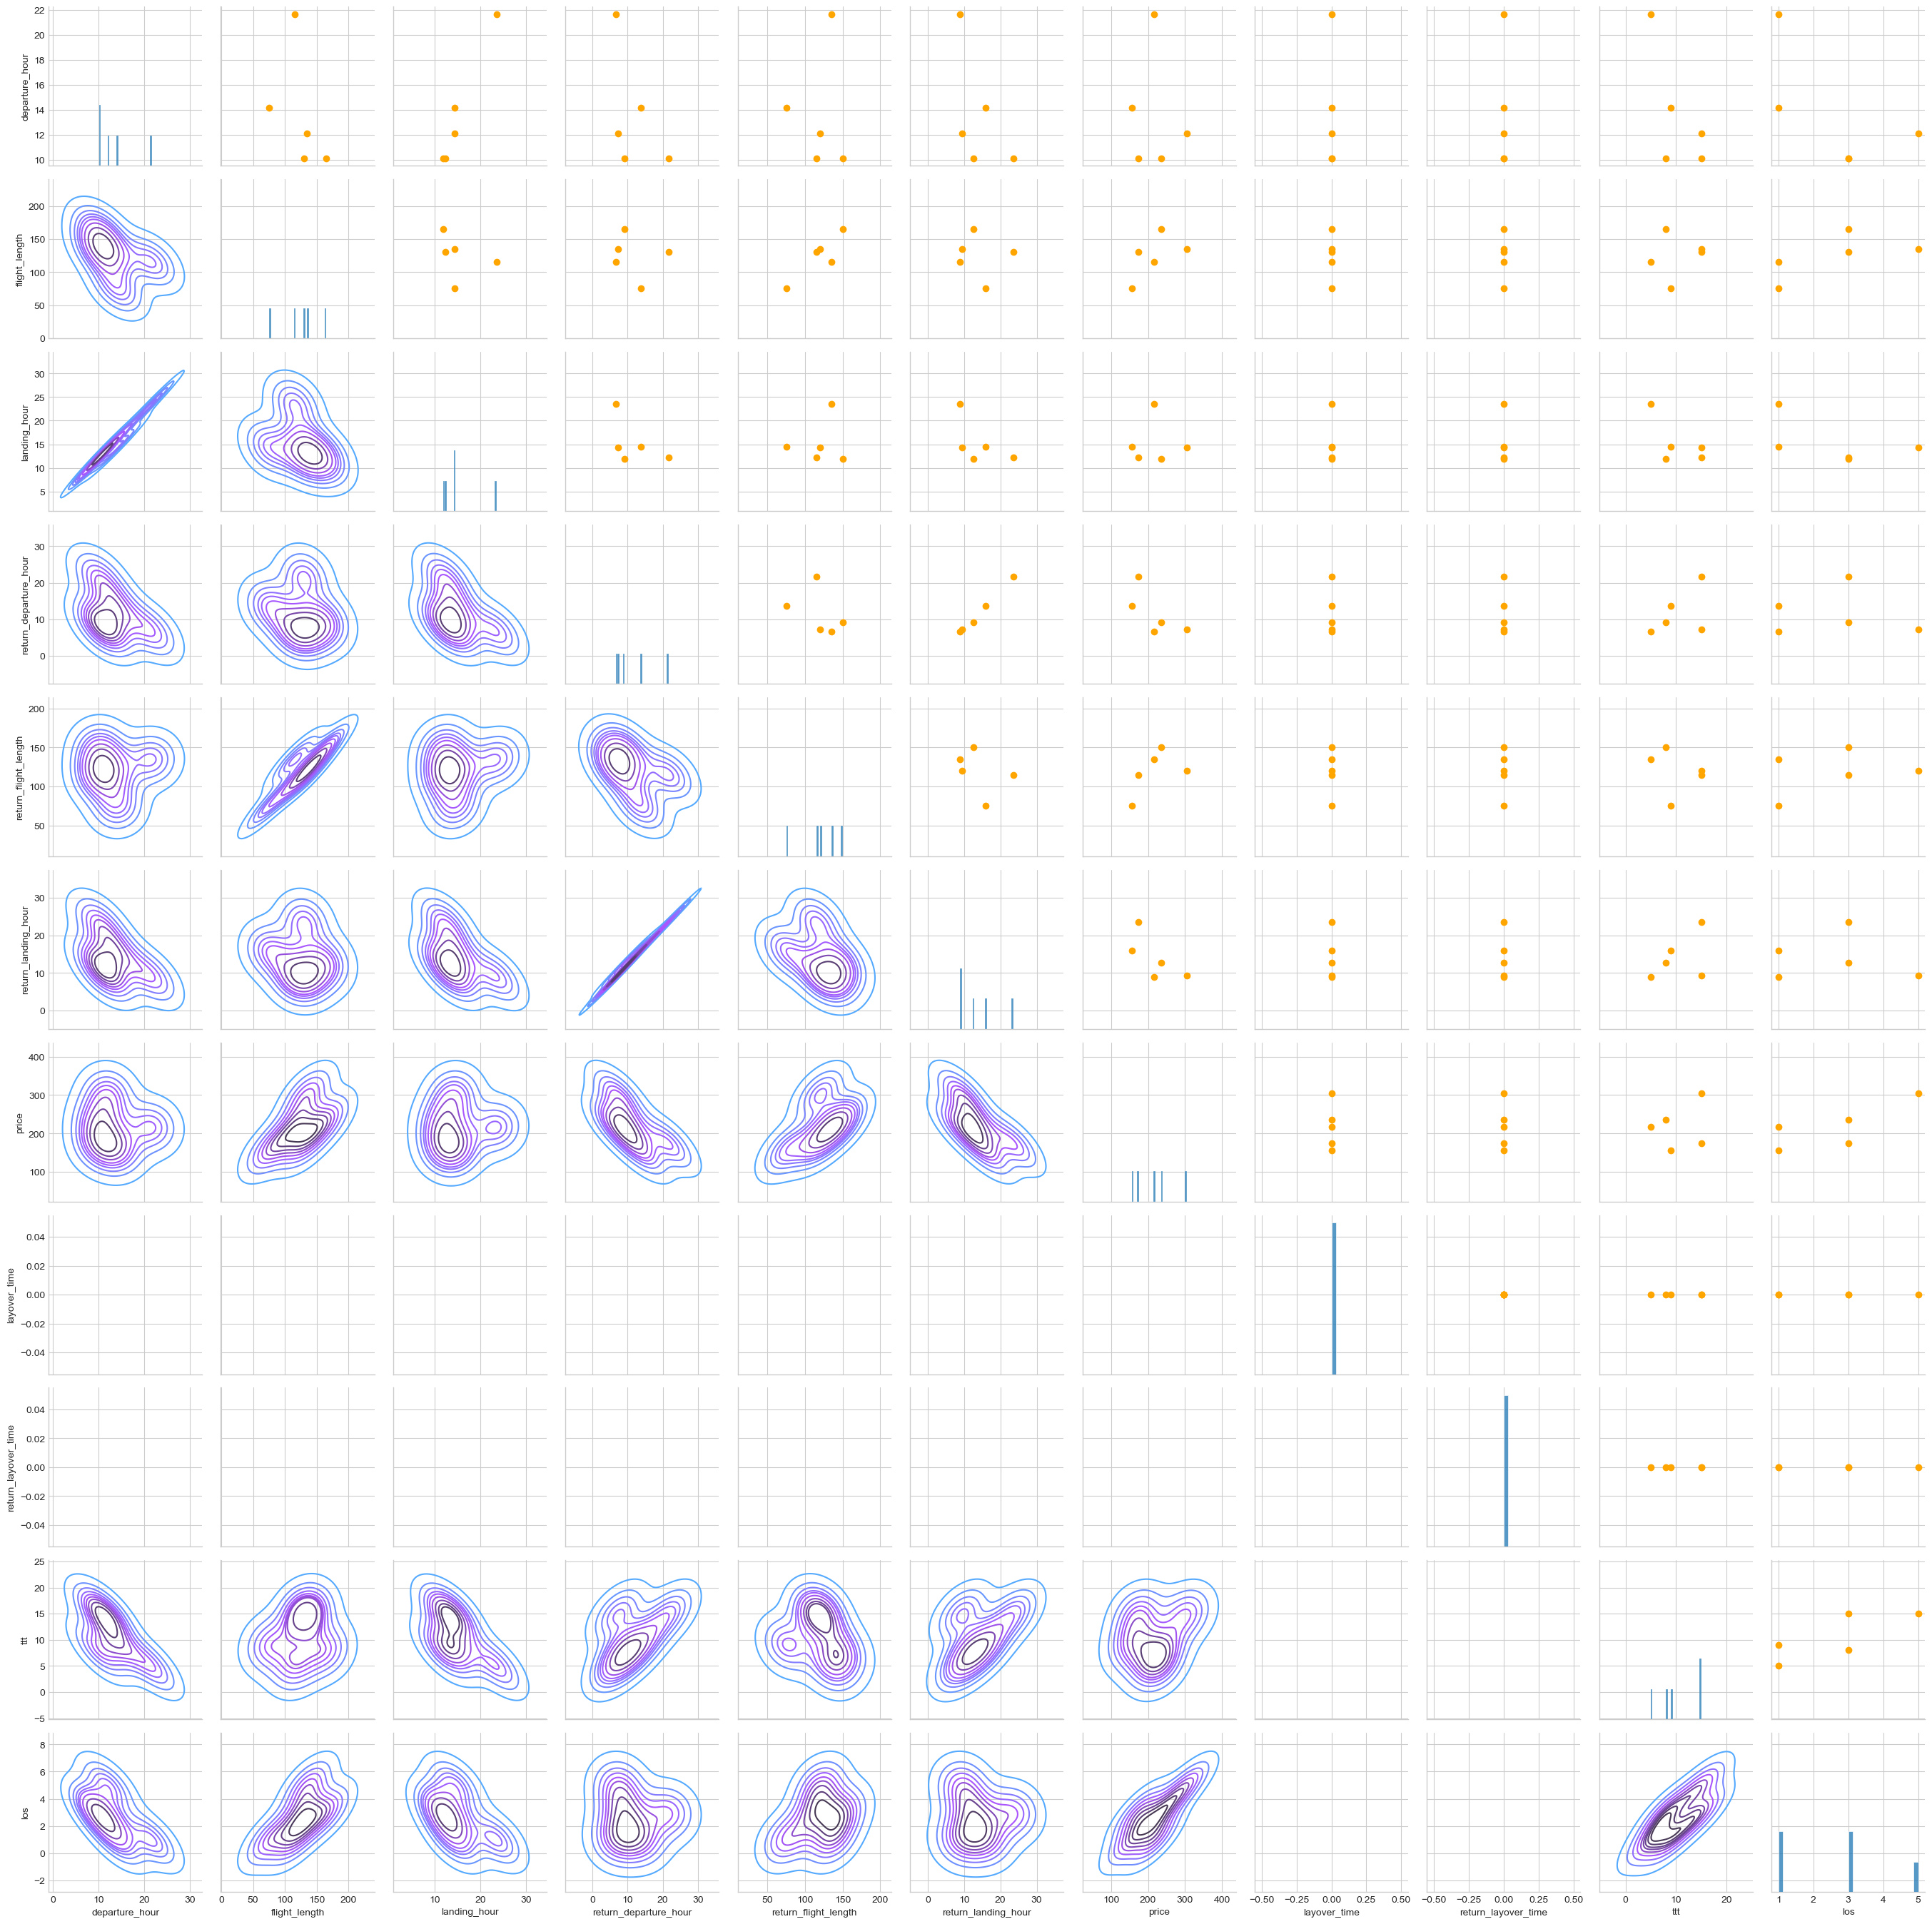

In [132]:
plt.figure(figsize=(20.0,16))
numeric_cols = ['departure_hour', 'flight_length', 'landing_hour', 
                'return_departure_hour', 'return_flight_length', 
                'return_landing_hour', 'price', 'layover_time', 
                'return_layover_time', 'ttt', 'los']
sampled_data = data_cleaned.sample(5, random_state=random_state)
pair_grid = sns.PairGrid(sampled_data[numeric_cols])
pair_grid.map_upper(plt.scatter,color='orange')
pair_grid.map_lower(sns.kdeplot,cmap='cool_d')
pair_grid.map_diag(sns.histplot,bins=30)
pair_grid.savefig('pairplot.png')

theres is a strong corolation between the layover time and the flight time (outbound and return)
also between the price and the flight lenght (flight lenght is the total lenght of the outbount flight incloude layover time, the same for return_flight_lenght)

<Axes: >

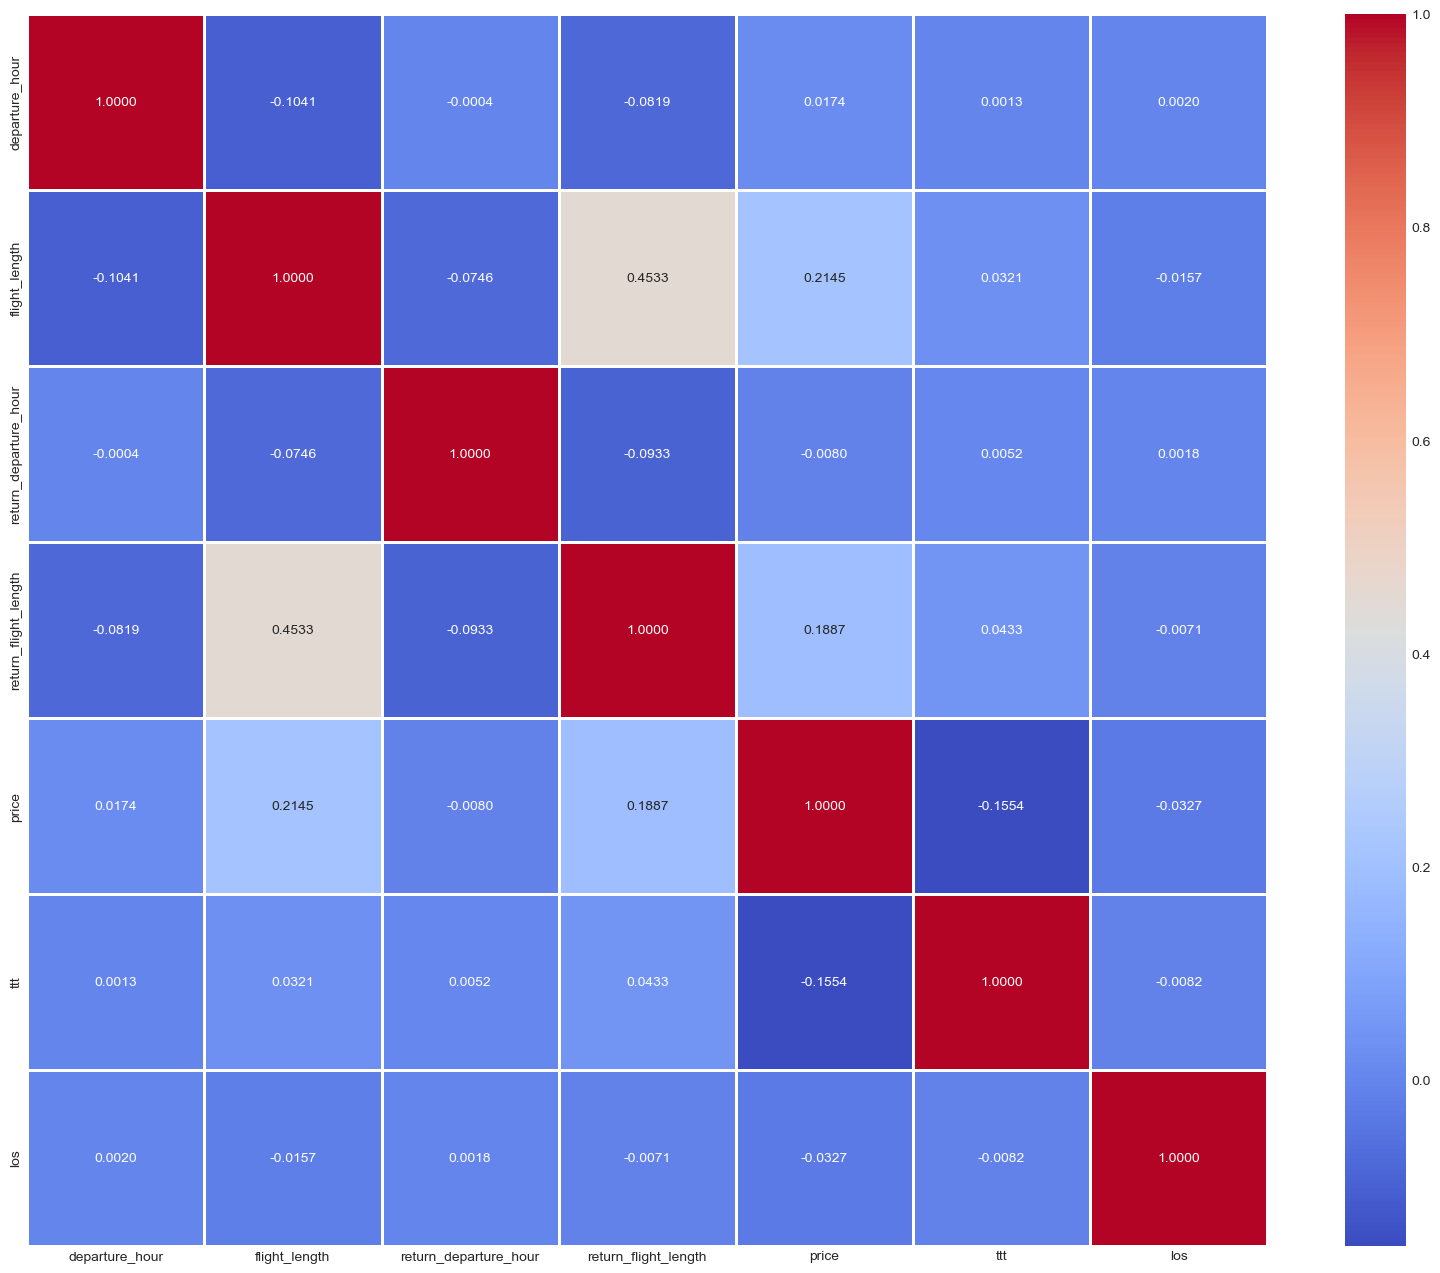

In [133]:
numeric_cols_refactored = ['departure_hour', 'flight_length', 'return_departure_hour', 'return_flight_length', 'price', 'ttt', 'los']
plt.figure(figsize=(20.0,16))
sns.heatmap(data[numeric_cols_refactored].corr(),annot=True,cmap='coolwarm',fmt='.4f',linewidths=2)

we can exclude the corr(return_flight_lenght,flight_lenght) because its the same distance (round trip), with domain knowlage we can tell that the corr is not 1 becase the Centrifugal force of earth spining makes one way shorter then the other.

### Insights:
- the flight lenghts will have the strongest corr with the price.
- ttt also has influance on the price
- the los influance on the price is very low

Insights - 
It can be seen that no numerical feature generate strong correlation with the target feature of price - 
The leading features are - 
<ul>
    <li>flight_length - 0.22</li>
</ul>
 

## Stage 5: Evaluation and baseline creation

#### lets split to train and test data

In [186]:
sample = data.sample(1000, random_state=random_state)
y = sample.price
X = sample.drop(["price"], axis=1)

X, X_test, y, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

## Processing Data for baseline
We need to convert the type of all the object in the dataset to category, as object sometimes can cause error when running models (because it is not recognizable). 
</br>
In addition we need to address the Encoding of categorical features and the standardization/normalization of the data

In [187]:
def convert_object_to_category(df):
    for feature in df.select_dtypes(include='object').columns:
        df[feature] = df[feature].astype('category')

X["departure_date"] = X["departure_date"].astype(str)
convert_object_to_category(X)

### Categorical Encoding
From looking at the categorical features in the dataframe we can infer that the relevant categorical methods may be the following 
<ul>
    <li>OneHotEncoding (get_dummies) - probably the most robust option</li>
    <li>TargetEncoder - might be sensitive to overfitting if used incorrectly</li>
    <li>HashingEncoder - </li>
    <li>CountEncoder</li>
</ul>

In [188]:
def categorical_encoding(X, encoding_type='onehot', y = None, hash_n_features=8):

    categorical_cols = X.select_dtypes(include='category').columns

    if encoding_type == 'onehot':
        X = pd.get_dummies(X, columns=categorical_cols)

    # Note target encoding is sensitive to overfitting
    elif encoding_type == 'target':
        if y:
            encoder = TargetEncoder(cols=categorical_cols)
            X = encoder.fit_transform(X, y)
        else:
            raise ValueError("target_column must be provided for target encoding.")

    elif encoding_type == 'hash':
        encoder = HashingEncoder(cols=categorical_cols, n_features=hash_n_features)
        X = encoder.fit_transform(X)

    elif encoding_type == 'count':
        encoder = CountEncoder(cols=categorical_cols)
        X = encoder.fit_transform(X)

    return X

### Normalization / standartization

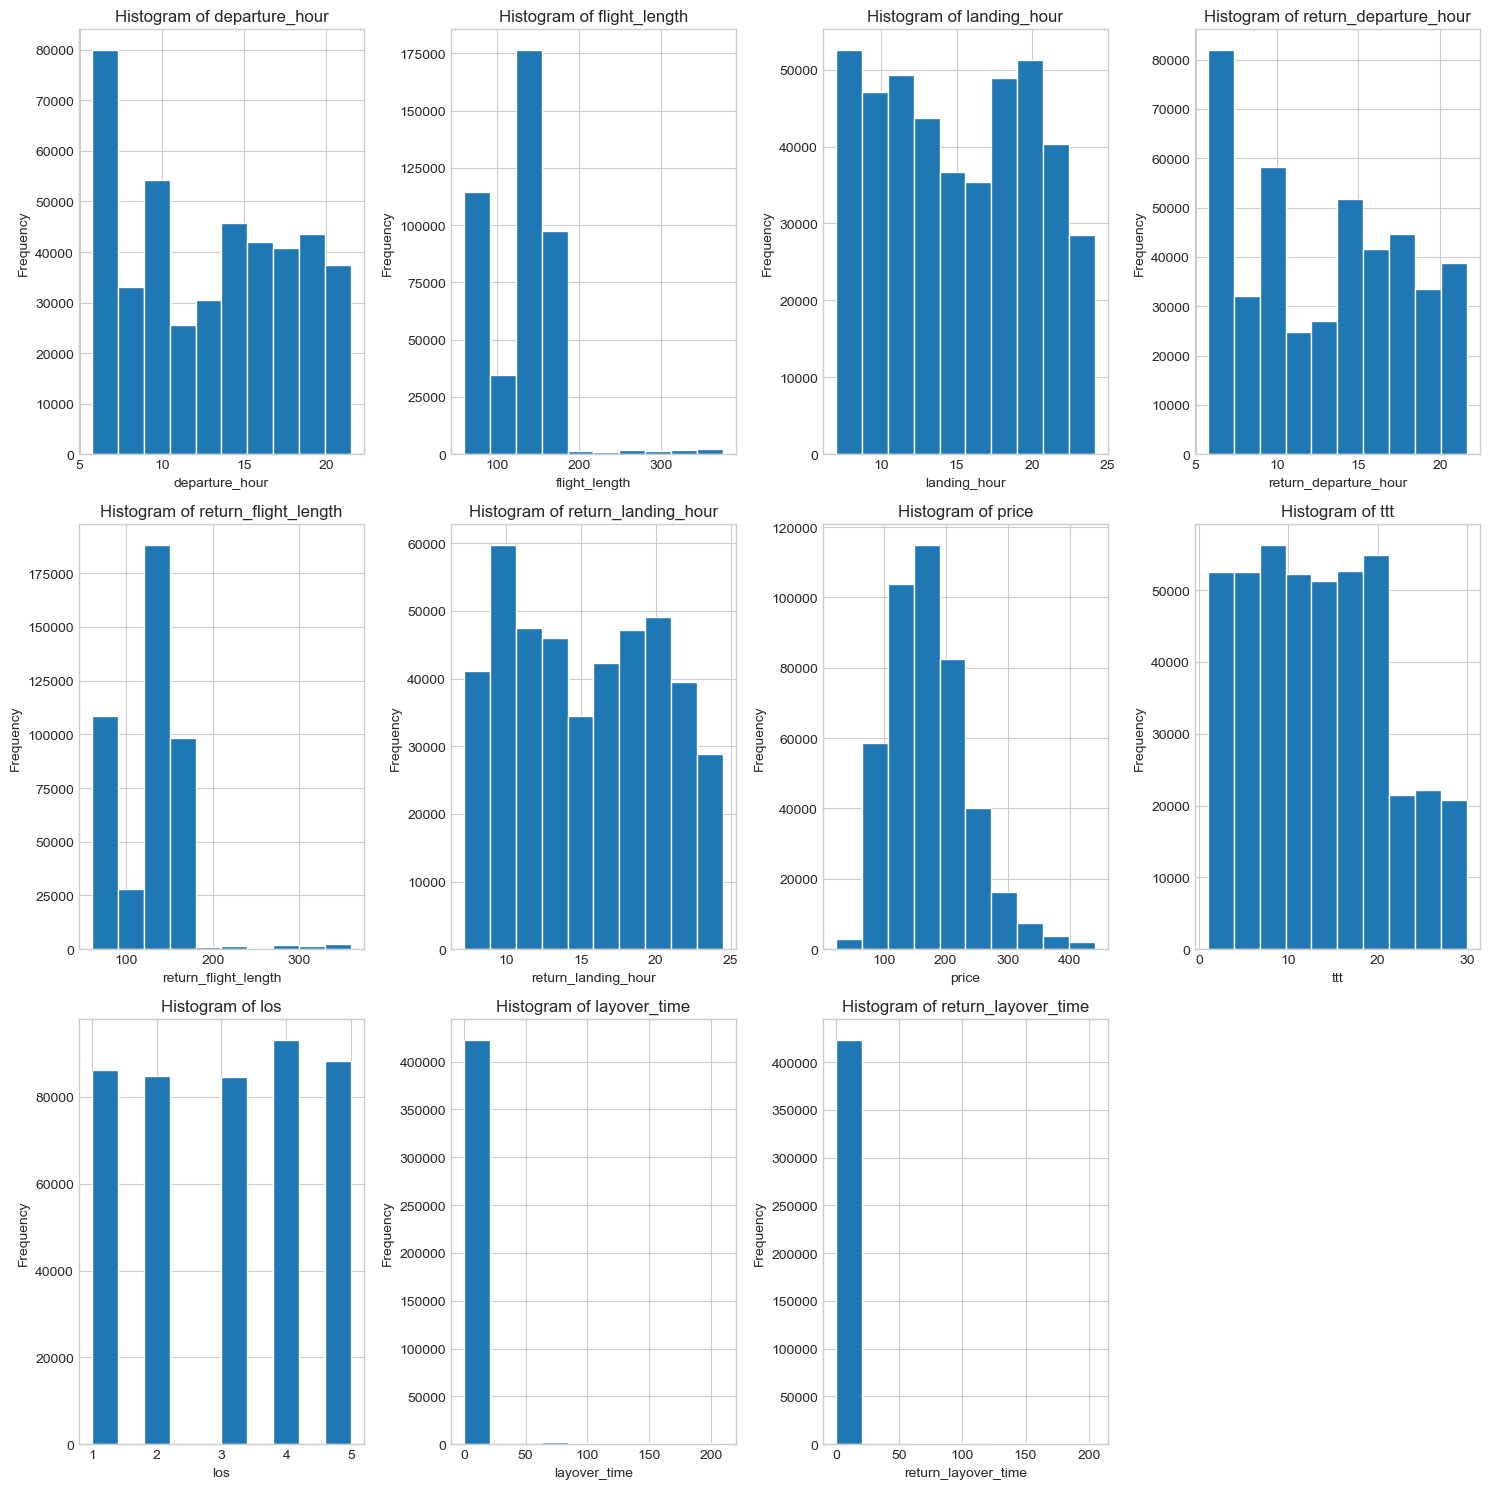

In [ ]:
import math
def histogram_new_features(df, rows):
    """
    Plots histograms for all numeric columns in the DataFrame 

    Args:
    df: The input DataFrame.
    rows: The number of rows in the grid layout.
    """
    df_cols = df.columns
    percentiles = df.quantile(0.99)
    
    cols_per_row = math.ceil(len(df_cols) / rows)
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(15, 5*rows))
    
    # Ensure axes is always 2D
    if rows == 1:
        axes = axes.reshape(1, -1)
    elif cols_per_row == 1:
        axes = axes.reshape(-1, 1)

    for i, col in enumerate(df_cols):
        row, col_idx = i // cols_per_row, i % cols_per_row
        
        filtered_data = df[col][df[col] <= percentiles[col]]
        ax = axes[row, col_idx]
        filtered_data.hist(ax=ax)
        ax.set_title(f"Histogram of {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Frequency")

    # Hide any unused subplots
    for i in range(len(df_cols), rows * cols_per_row):
        row, col_idx = i // cols_per_row, i % cols_per_row
        axes[row, col_idx].axis('off')

    plt.tight_layout()
    plt.show()

# Usage
num_columns = data.select_dtypes(include='number').columns.tolist()
histogram_new_features(data[num_columns], rows=3)

Results - Non of the numerical features follow guassian distribution therefore normalization might be the superior option to optimize results

In [ ]:
def normalize_numerical_features(df, numerical_columns):
    """Normalizes numerical features in a DataFrame to the range [0, 1]."""

    scaler = MinMaxScaler()
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
    return df

In [ ]:
# Create rmse loss function
def custom_rmse(y_true, y_pred):
    return abs(np.sqrt(mean_squared_error(y_true, y_pred)))

def evaluate_models(train, y):
    cv = KFold(n_splits=5, shuffle=True, random_state=random_state)

    models = [
        CatBoostRegressor(verbose=False),
        LGBMRegressor(verbose=-1),
        XGBRegressor(),
        RandomForestRegressor(),
        LinearRegression(),
        DecisionTreeRegressor(),
        GaussianProcessRegressor()
    ]

    models_names = [
        "CatBoostRegressor",
        "LGBMRegressor",
        "XGBRegressor",
        "RandomForestRegressor",
        "LinearRegression",
        "DecisionTreeRegressor",
        "GaussianProcessRegressor"
    ]

    # Define scoring metrics
    scoring_metrics = {
        "MSE": make_scorer(mean_squared_error),
        "RMSE": make_scorer(custom_rmse, greater_is_better=False),
        "MAE": make_scorer(mean_absolute_error),
        "R2": make_scorer(r2_score)
    }

    results = {metric: [] for metric in scoring_metrics.keys()}

    for model in models:
        for metric, scorer in scoring_metrics.items():
            scores = cross_val_score(model, train, y, scoring=scorer, cv=cv, n_jobs=-1)
            results[metric].append(scores.mean())

    # Create DataFrame
    cv_res = pd.DataFrame(results)
    cv_res["Algorithm"] = models_names

    pd.options.display.float_format = '{:.4f}'.format

    return cv_res

In [163]:
print("Baseline model evaluation - only numerical features")

start_time = time.time()

# Evaluate models Only numeric
X_numeric = X.select_dtypes(include='number')
display(evaluate_models(X_numeric, y))

end_time = time.time()

elapsed_time = end_time - start_time
print("Evaluation time:", elapsed_time, "seconds")


Baseline model evaluation - only numerical features


,MSE,RMSE,MAE,R2,Algorithm
0,2153.4585,-46.2568,36.5210,0.3512,CatBoostRegressor
1,2223.3761,-47.0421,36.9305,0.3252,LGBMRegressor
2,2452.2445,-49.4155,39.1791,0.2581,XGBRegressor
3,2132.1320,-45.5677,36.5501,0.3565,RandomForestRegressor
4,2864.5641,-53.4246,43.9221,0.1346,LinearRegression
5,3655.5961,-60.6163,46.6462,-0.0965,DecisionTreeRegressor
6,29843.1533,-172.7405,162.0706,-8.1671,GaussianProcessRegressor


Evaluation time: 22.43957757949829 seconds


In [195]:
print("Baseline model evaluation - onehot encoding")
start_time = time.time()

X = categorical_encoding(X)
display(evaluate_models(X, y))

end_time = time.time()

elapsed_time = end_time - start_time
print("Evaluation time:", elapsed_time, "seconds")

Baseline model evaluation - onehot encoding


,MSE,RMSE,MAE,R2,Algorithm
0,1193.4996,-34.5025,27.2998,0.6391,CatBoostRegressor
1,1505.4523,-38.7711,30.2964,0.5420,LGBMRegressor
2,1383.1223,-37.1228,29.0996,0.5825,XGBRegressor
3,1454.5267,-37.5505,30.3196,0.5595,RandomForestRegressor
4,468466242805841199104.0000,-10949095159.8157,936938843.8125,-126832157052478112.0000,LinearRegression
5,2659.5723,-53.1600,40.3568,0.0907,DecisionTreeRegressor
6,30806.1181,-175.5061,165.7298,-8.4594,GaussianProcessRegressor


Evaluation time: 59.03557562828064 seconds


<h3>Feature Engineering</h3>
After We created the baseline 

### Hyperparameters Tuning
An important part of the data science project structure is Hyperparameters Tuning which involves on tuning the parameters each model have using various techniques. 
We decided to use the library optuna, as it usually provides robust solution and it inclined to find good results

In [201]:
def objective_catboost(trial, X_train, y_train):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10),
        'random_strength': trial.suggest_uniform('random_strength', 1, 20),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 1, 255),
    }

    model = CatBoostRegressor(**params, verbose=0, early_stopping_rounds=50)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, scoring=make_scorer(custom_rmse, greater_is_better=False), cv=cv, n_jobs=-1)

    return abs(np.mean(score))  # Optuna tries to minimize, so we negate RMSE


# XGBoost
def objective_xgboost(trial, X_train, y_train):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10),
    }

    model = XGBRegressor(**params)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, scoring=make_scorer(custom_rmse, greater_is_better=False), cv=cv, n_jobs=-1)

    return abs(np.mean(score))


# LightGBM
def objective_lightgbm(trial, X_train, y_train):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
    }

    model = LGBMRegressor(**params)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, scoring=make_scorer(custom_rmse, greater_is_better=False), cv=cv, n_jobs=-1)

    return abs(np.mean(score))


# RandomForest
def objective_randomforest(trial, X_train, y_train):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 4, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
    }

    model = RandomForestRegressor(**params)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, scoring=make_scorer(custom_rmse, greater_is_better=False), cv=cv, n_jobs=-1)

    return abs(np.mean(score))


# DecisionTreeRegressor
def objective_decisiontree(trial, X_train, y_train):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
    }

    model = DecisionTreeRegressor(**params, random_state=42)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, scoring=make_scorer(custom_rmse, greater_is_better=False), cv=cv, n_jobs=-1)

    return abs(np.mean(score))

# GaussianProcessRegressor
def objective_gaussianprocess(trial, X_train, y_train):
    kernel_type = trial.suggest_categorical('kernel', ['RBF', 'Matern', 'RationalQuadratic'])
    length_scale = trial.suggest_loguniform('length_scale', 1e-1, 1e2)

    if kernel_type == 'RBF':
        kernel = RBF(length_scale=length_scale)
    elif kernel_type == 'Matern':
        nu = trial.suggest_categorical('nu', [0.5, 1.5, 2.5])
        kernel = Matern(length_scale=length_scale, nu=nu)
    elif kernel_type == 'RationalQuadratic':
        alpha = trial.suggest_loguniform('alpha', 1e-1, 1e2)
        kernel = RationalQuadratic(length_scale=length_scale, alpha=alpha)

    model = GaussianProcessRegressor(kernel=kernel, random_state=42)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, scoring=make_scorer(custom_rmse, greater_is_better=False), cv=cv, n_jobs=-1)

    return abs(np.mean(score))

# LinearRegression (no hyperparameters to tune)
def objective_lr(trial, X_train, y_train):
    model = LinearRegression()
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, scoring=make_scorer(custom_rmse, greater_is_better=False), cv=cv, n_jobs=-1)

    return abs(np.mean(score))

In [202]:
def tune_model(model_name, X_train, y_train):

    if model_name == 'CatBoost':
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective_catboost(trial, X_train, y_train), n_trials=50)
        best_params = study.best_params
        print(f"Best parameters for {model_name}: {best_params}")
        return best_params

    elif model_name == 'XGBoost':
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective_xgboost(trial, X_train, y_train), n_trials=50)
        best_params = study.best_params
        print(f"Best parameters for {model_name}: {best_params}")
        return best_params

    elif model_name == 'LightGBM':
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective_lightgbm(trial, X_train, y_train), n_trials=50)
        best_params = study.best_params
        print(f"Best parameters for {model_name}: {best_params}")
        return best_params

    elif model_name == 'DecisionTree':
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective_decisiontree(trial, X_train, y_train), n_trials=50)
        best_params = study.best_params
        print(f"Best parameters for {model_name}: {best_params}")
        return best_params

    elif model_name == 'GaussianProcess':
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective_gaussianprocess(trial, X_train, y_train), n_trials=50)
        best_params = study.best_params
        print(f"Best parameters for {model_name}: {best_params}")
        return best_params

    elif model_name == 'RandomForest':
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective_randomforest(trial, X_train, y_train), n_trials=50)
        best_params = study.best_params
        print(f"Best parameters for {model_name}: {best_params}")
        return best_params

    elif model_name == 'LinearRegression':
        print("No hyperparameters to tune for Linear Regression.")
        return "No hyperparameters tuned for Linear Regression."

    else:
        print(f"Model '{model_name}' not recognized.")
        return None

In [203]:
catboost_best_params = tune_model('CatBoost', X, y)

[I 2025-03-19 03:10:49,377] A new study created in memory with name: no-name-f16892cb-acd3-42bd-8c45-3353af323b97
C:\Users\Nadav\AppData\Local\Temp\ipykernel_26456\1153519005.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\Nadav\AppData\Local\Temp\ipykernel_26456\1153519005.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10),
C:\Users\Nadav\AppData\Local\Temp\ipykernel_26456\1153519005.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/op

KeyboardInterrupt: 

## Analyzing results using SHAP values and feature importance  

In [207]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import shap
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

def analyze_single_model(model, X, y, n_top_features=15, model_name="Model"):
    """
    Analyze a single model by displaying feature importance and SHAP values.

    Parameters:
    model : The trained model to analyze
    X : pandas DataFrame
        The feature dataset
    y : pandas Series or numpy array
        The target variable
    n_top_features : int, optional (default=15)
        Number of top features to display in plots
    model_name : str, optional (default="Model")
        Name of the model for plot titles
    """

    feature_names = X.columns

    def plot_feature_importance(importances, title, ax):
        # Sort importances in descending order for plotting
        indices = np.argsort(importances)[::-1][:n_top_features]
        top_importances = importances[indices]
        top_features = [feature_names[i] for i in indices]

        colors = cm.Blues(np.linspace(0.5, 1, len(top_importances)))

        bars = ax.bar(top_features, top_importances, color=colors)
        ax.set_title(title)
        ax.set_xticks(range(len(top_features)))
        ax.set_xticklabels(top_features, rotation=90)

        # Add value labels at the top of each bar
        for bar, imp in zip(bars, top_importances):
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{imp:.2f}',
                    ha='center', va='bottom', color='black', fontweight='bold')

    def get_feature_importance(model):
        if hasattr(model, 'feature_importances_'):
            return model.feature_importances_
        elif isinstance(model, LinearRegression):
            return np.abs(model.coef_)
        else:
            return None

    def get_shap_values(model, X):
        if isinstance(model, (RandomForestRegressor)) or type(model).__name__ in ['LinearRegression', 'GradientBoostingRegressor', 'XGBRegressor', 'LGBMRegressor', 'CatBoostRegressor']:
            explainer = shap.TreeExplainer(model)
            return explainer.shap_values(X)

    # Feature Importance Plot
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
    importances = get_feature_importance(model)
    if importances is not None:
        plot_feature_importance(importances, f"Feature Importance - {model_name}", ax1)
    else:
        ax1.text(0.5, 0.5, "Feature importance not available", ha='center', va='center')

    plt.tight_layout()
    plt.show()

    # SHAP Values Beeswarm Plot
    try:
        shap_values = get_shap_values(model, X)
        plt.figure(figsize=(8, 6))
        shap.summary_plot(shap_values, X, plot_type="dot", max_display=n_top_features, show=False)
        plt.show() # added plt.show()
    except Exception as e:
        print(f"Error computing SHAP values for {model_name}: {e}")

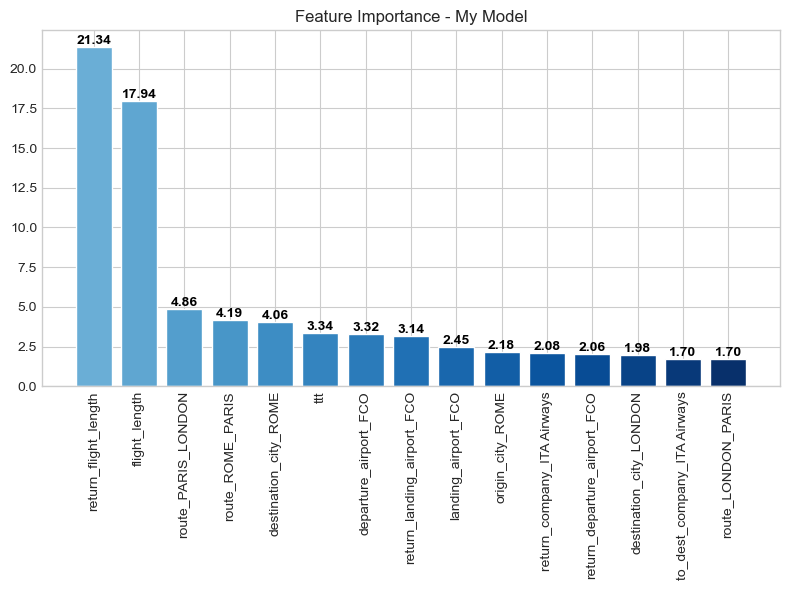

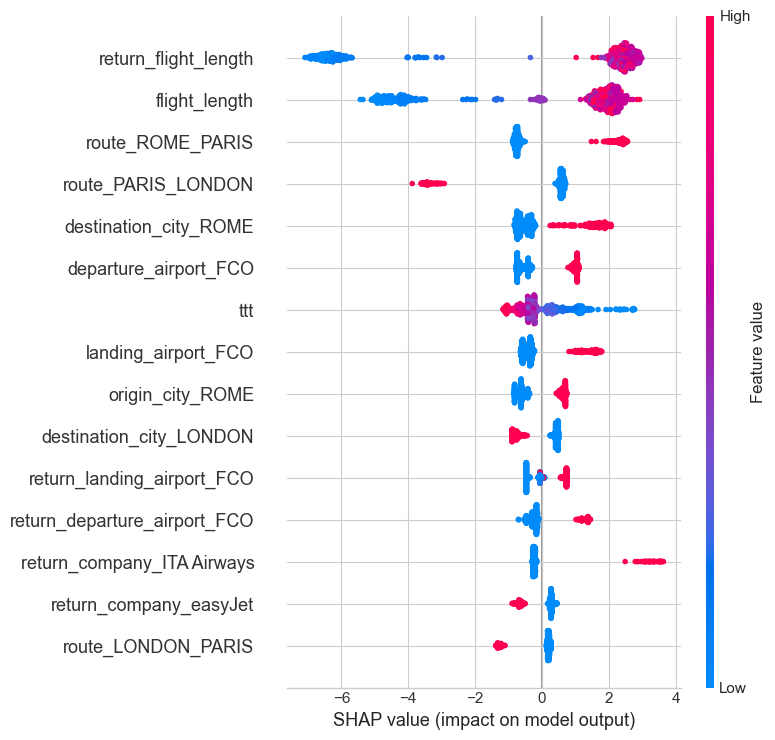

In [208]:
# Example usage for CatBoost
catboost = CatBoostRegressor(**catboost_best_params, verbose=0, early_stopping_rounds=50)
catboost.fit(X, y)

analyze_single_model(catboost, X, y, model_name="My Model")